***
### CAPSTONE PROJECT 3: FEATURE ENGINEERING/PRE-PROCESSING/MODELING ###
***
- Review the PCA's generated from the DATA CLEANING/EDA 
- Determine how many PCAs required
- Deterrmine if only most important Eigen values from PCAs would be sufficient to model.
- separate table into X and y sets.
- create Train and test data sets.
- setup ARIMA models
- setup LSTM Model
- setup VAR model.
- train models
- evaluate models.
- decide which model serves best and why.

In [1]:
# Basic Data Science Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# Models to test and scalar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
#   LSTM
import warnings 
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# VARMAX
from statsmodels.tsa.statespace.varmax import VARMAX

# Model Metrics
from sklearn.metrics import mean_squared_error


2024-05-29 09:23:05.696632: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


***
##### FEATURE ENGINEERING
***
Determine Number of PCA's Required or if only important Eigen values from PCAs would be sufficient for our model

In [2]:
# Linux
bitcoin_df = pd.read_csv('./Data/bitcoin_df_cleaned')
most_important_features = pd.read_csv('./Data/most_important_features')

# Windows
# bitcoin_df = pd.read_csv(r'C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_3\Data\bitcoin_df_cleaned')
# most_important_features = pd.read_csv(r'C:\Users\micha\OneDrive\Documents\GitHub\SpringBoardDataScience\Capstone_Project_3\Data\most_important_features')

In [3]:
bitcoin_df.head()

,date,USD Exchange Trade Volume,Total Transaction Fees USD,Total Transaction Fees,Total Output Volume,Total Bitcoins,Transaction Excluding Popular Addresses,Number of Transactions per Block,Total Number of Transactions,Number of Transactions,...,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12
0,2009-01-03,0.0,0.0,0.0,0.0,50.0,0.0,1.0,1.0,0.0,...,0.569005,-0.568879,-0.054665,-0.091244,0.242654,0.28525,-0.60444,-0.121818,0.364128,-0.185659
1,2009-01-04,0.0,0.0,0.0,0.0,50.0,0.0,1.0,1.0,0.0,...,0.569005,-0.568879,-0.054665,-0.091244,0.242654,0.28525,-0.60444,-0.121818,0.364128,-0.185659
2,2009-01-05,0.0,0.0,0.0,0.0,50.0,0.0,1.0,1.0,0.0,...,0.569005,-0.568879,-0.054665,-0.091244,0.242654,0.28525,-0.60444,-0.121818,0.364128,-0.185659
3,2009-01-06,0.0,0.0,0.0,0.0,50.0,0.0,1.0,1.0,0.0,...,0.569005,-0.568879,-0.054665,-0.091244,0.242654,0.28525,-0.60444,-0.121818,0.364128,-0.185659
4,2009-01-07,0.0,0.0,0.0,0.0,50.0,0.0,1.0,1.0,0.0,...,0.569005,-0.568879,-0.054665,-0.091244,0.242654,0.28525,-0.60444,-0.121818,0.364128,-0.185659


In [4]:
bitcoin_df.columns

Index(['date', 'USD Exchange Trade Volume', 'Total Transaction Fees USD',
       'Total Transaction Fees', 'Total Output Volume', 'Total Bitcoins',
       'Transaction Excluding Popular Addresses',
       'Number of Transactions per Block', 'Total Number of Transactions',
       'Number of Transactions', 'Number of Unique Addresses Used',
       'My Wallet Transaction Volume', 'My Wallet Number of Users',
       'Number of Transactions per Day', 'Market Capitalization',
       'Market Price', 'Miners Revenue', 'Hash Rate',
       'Estimated Transaction Volume USD', 'Estimated Transaction Volume',
       'Difficulty', 'Cost Percent of Transaction Volume',
       'Cost per Transaction', 'API Blockchain Size', 'Average Block Size',
       'Median Transaction Confirmation Time', 'PCA1', 'PCA2', 'PCA3', 'PCA4',
       'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10', 'PCA11', 'PCA12'],
      dtype='object')

In [5]:
print(most_important_features['Feature Name'])

0                             Difficulty
1                  Market Capitalization
2       Estimated Transaction Volume USD
3              USD Exchange Trade Volume
4           Total Number of Transactions
5                              Hash Rate
6              My Wallet Number of Users
7                         Miners Revenue
8                         Total Bitcoins
9                    Total Output Volume
10            Total Transaction Fees USD
11    Cost Percent of Transaction Volume
Name: Feature Name, dtype: object


Since we're dealing with Cybercurrency rather than stocks, we should resample this data taking the final value per month and also start performing percentchanges per column and autocorrelation functions as we curate a final feature set with which to model.

In [6]:
bitcoin_df.head()

,date,USD Exchange Trade Volume,Total Transaction Fees USD,Total Transaction Fees,Total Output Volume,Total Bitcoins,Transaction Excluding Popular Addresses,Number of Transactions per Block,Total Number of Transactions,Number of Transactions,...,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12
0,2009-01-03,0.0,0.0,0.0,0.0,50.0,0.0,1.0,1.0,0.0,...,0.569005,-0.568879,-0.054665,-0.091244,0.242654,0.28525,-0.60444,-0.121818,0.364128,-0.185659
1,2009-01-04,0.0,0.0,0.0,0.0,50.0,0.0,1.0,1.0,0.0,...,0.569005,-0.568879,-0.054665,-0.091244,0.242654,0.28525,-0.60444,-0.121818,0.364128,-0.185659
2,2009-01-05,0.0,0.0,0.0,0.0,50.0,0.0,1.0,1.0,0.0,...,0.569005,-0.568879,-0.054665,-0.091244,0.242654,0.28525,-0.60444,-0.121818,0.364128,-0.185659
3,2009-01-06,0.0,0.0,0.0,0.0,50.0,0.0,1.0,1.0,0.0,...,0.569005,-0.568879,-0.054665,-0.091244,0.242654,0.28525,-0.60444,-0.121818,0.364128,-0.185659
4,2009-01-07,0.0,0.0,0.0,0.0,50.0,0.0,1.0,1.0,0.0,...,0.569005,-0.568879,-0.054665,-0.091244,0.242654,0.28525,-0.60444,-0.121818,0.364128,-0.185659


In [7]:
# Linux Machine
bitcoin_df['date'] = pd.to_datetime(bitcoin_df['date'])
bitcoin_df.set_index('date', inplace=True)
monthly_bitcoin_df = bitcoin_df.resample(rule='ME').last()

# Windows Machine
# bitcoin_df['date'] = pd.to_datetime(bitcoin_df['date'])
# bitcoin_df.set_index('date', inplace=True)
# monthly_bitcoin_df = bitcoin_df.resample(rule='M').last()

In [8]:
monthly_bitcoin_df.head()

,USD Exchange Trade Volume,Total Transaction Fees USD,Total Transaction Fees,Total Output Volume,Total Bitcoins,Transaction Excluding Popular Addresses,Number of Transactions per Block,Total Number of Transactions,Number of Transactions,Number of Unique Addresses Used,...,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12
date,,,,,,,,,,,,,,,,,,,,,
2009-01-31,0.0,0.0,0.0,6900.0,131350.0,118.0,1.0000,2660.0,118.0,118.0,...,0.565030,-0.563939,-0.054191,-0.089885,0.239737,0.282748,-0.602849,-0.120739,0.357469,-0.182035
2009-02-28,0.0,0.0,0.0,5650.0,300350.0,107.0,1.0101,5894.0,100.0,107.0,...,0.560211,-0.563640,-0.051130,-0.094561,0.240379,0.281682,-0.597189,-0.119256,0.350008,-0.177898
2009-03-31,0.0,0.0,0.0,7100.0,473700.0,111.0,1.0000,9564.0,107.0,107.0,...,0.555188,-0.561716,-0.052657,-0.099386,0.240415,0.280493,-0.592182,-0.117801,0.342172,-0.173529
2009-04-30,0.0,0.0,0.0,6550.0,646200.0,131.0,1.0000,13031.0,123.0,123.0,...,0.550199,-0.559929,-0.051917,-0.102584,0.239699,0.277679,-0.587518,-0.116157,0.334166,-0.169215
2009-05-31,0.0,0.0,0.0,3700.0,814050.0,74.0,1.0000,16407.0,74.0,97.0,...,1.580360,-3.325415,61.876607,19.669443,-3.406495,-0.765949,1.014664,0.145786,-0.260525,0.111816


In [9]:
most_important_features_list = list(most_important_features['Feature Name'].unique())

In [10]:
def feature_correlation(df, feature_list):
    pct_change_df = pd.DataFrame()
    for feature in feature_list:
       pct_change_df[f'{feature}_RET']  = df[feature].pct_change()
       
    corr = pct_change_df.corr()
    sns.heatmap(corr)

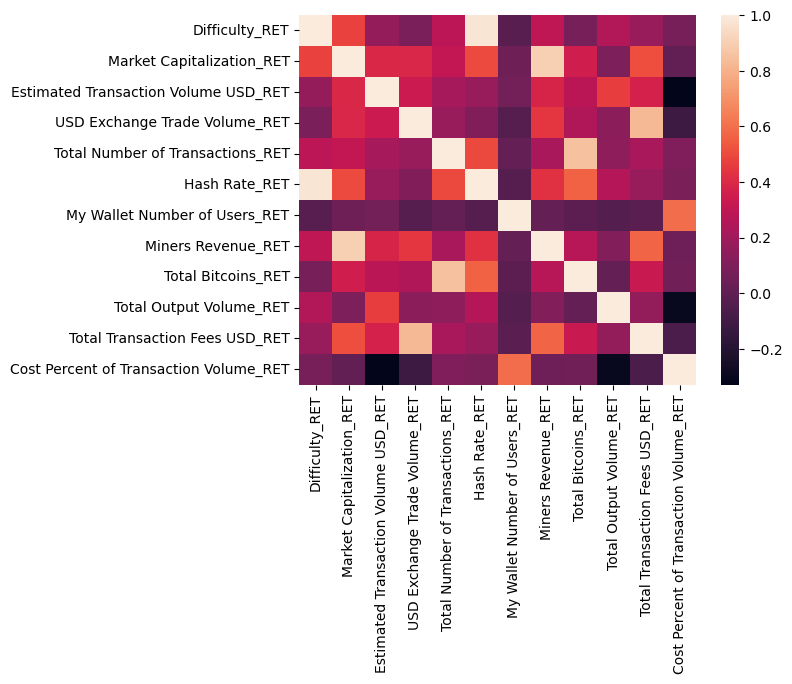

In [11]:
_ = feature_correlation(monthly_bitcoin_df, most_important_features_list)

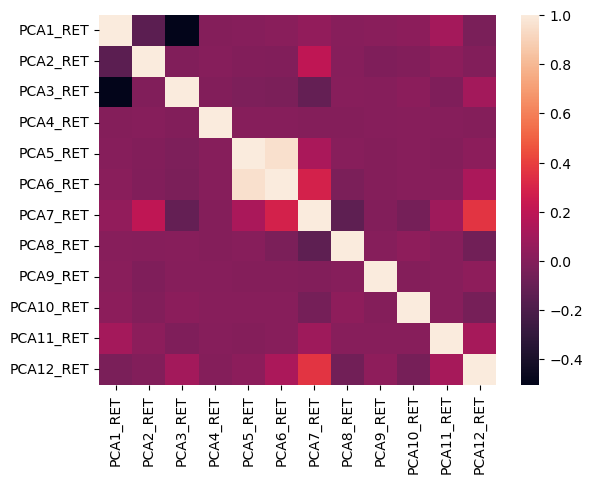

In [12]:
PCA_list = ['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10', 'PCA11', 'PCA12']
_ = feature_correlation(monthly_bitcoin_df, PCA_list)

These heatmaps pretty clearly say that for our feature set, we should use our curated PCAs rather then the primary Eigen values particularly since their degree of correlation is almost all zero which means little to no correlation between these PC vectors.  which for a multivariate time series analysis is exactly what we want.  NO CONFOUNDING VARIABLES!

In [13]:
monthly_pca_bitcoin_df = monthly_bitcoin_df[PCA_list]
monthly_pca_bitcoin_df['Market Price'] = monthly_bitcoin_df.loc[:,'Market Price']

/tmp/ipykernel_3781/203295870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_pca_bitcoin_df['Market Price'] = monthly_bitcoin_df.loc[:,'Market Price']


In [14]:
monthly_pca_bitcoin_df.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,Market Price
date,,,,,,,,,,,,,
2009-01-31,-4.303479,-1.979341,0.565030,-0.563939,-0.054191,-0.089885,0.239737,0.282748,-0.602849,-0.120739,0.357469,-0.182035,0.0
2009-02-28,-4.297004,-1.974127,0.560211,-0.563640,-0.051130,-0.094561,0.240379,0.281682,-0.597189,-0.119256,0.350008,-0.177898,0.0
2009-03-31,-4.290207,-1.967827,0.555188,-0.561716,-0.052657,-0.099386,0.240415,0.280493,-0.592182,-0.117801,0.342172,-0.173529,0.0
2009-04-30,-4.283464,-1.961293,0.550199,-0.559929,-0.051917,-0.102584,0.239699,0.277679,-0.587518,-0.116157,0.334166,-0.169215,0.0
2009-05-31,-4.717936,-3.377790,1.580360,-3.325415,61.876607,19.669443,-3.406495,-0.765949,1.014664,0.145786,-0.260525,0.111816,0.0


In [15]:
pct_change_df = pd.DataFrame()
for feature in PCA_list:
    pct_change_df[f'{feature}_RET']  = monthly_bitcoin_df[feature].pct_change()

In [16]:
for col in pct_change_df.columns:
    print(f'Autocorrelation for {col} is: {pct_change_df[col]}')

Autocorrelation for PCA1_RET is: date
2009-01-31         NaN
2009-02-28   -0.001505
2009-03-31   -0.001582
2009-04-30   -0.001572
2009-05-31    0.101430
                ...   
2024-01-31   -0.182696
2024-02-29    0.250034
2024-03-31   -0.156358
2024-04-30    0.016547
2024-05-31    0.046690
Freq: ME, Name: PCA1_RET, Length: 185, dtype: float64
Autocorrelation for PCA2_RET is: date
2009-01-31         NaN
2009-02-28   -0.002634
2009-03-31   -0.003192
2009-04-30   -0.003320
2009-05-31    0.722226
                ...   
2024-01-31    2.043564
2024-02-29    0.521250
2024-03-31    0.346441
2024-04-30   -0.258748
2024-05-31    0.036809
Freq: ME, Name: PCA2_RET, Length: 185, dtype: float64
Autocorrelation for PCA3_RET is: date
2009-01-31         NaN
2009-02-28   -0.008529
2009-03-31   -0.008966
2009-04-30   -0.008986
2009-05-31    1.872341
                ...   
2024-01-31   -1.125360
2024-02-29   -9.346899
2024-03-31   -1.069267
2024-04-30    3.164233
2024-05-31    0.415148
Freq: ME, Name: PCA

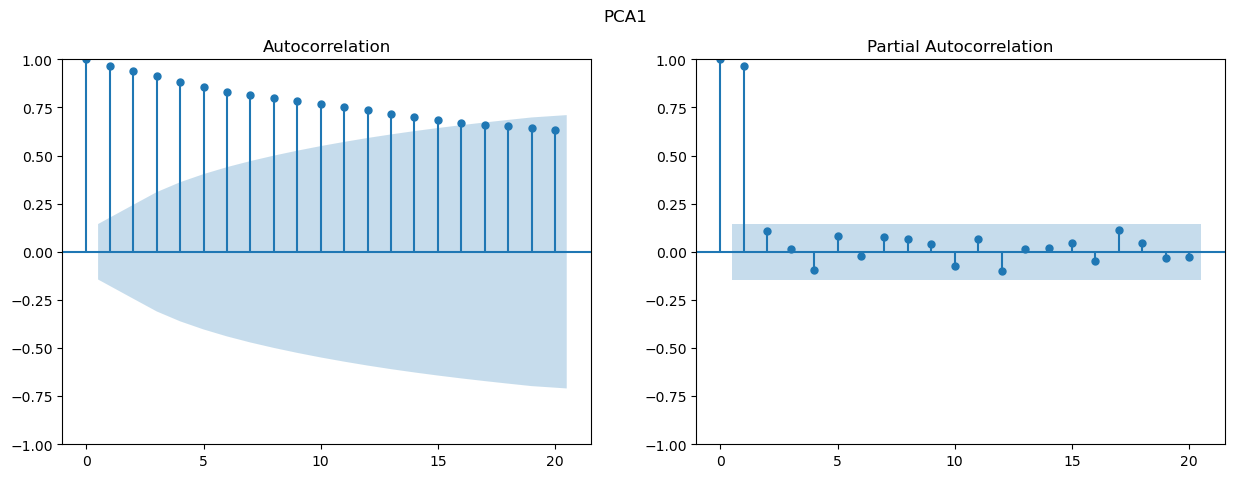

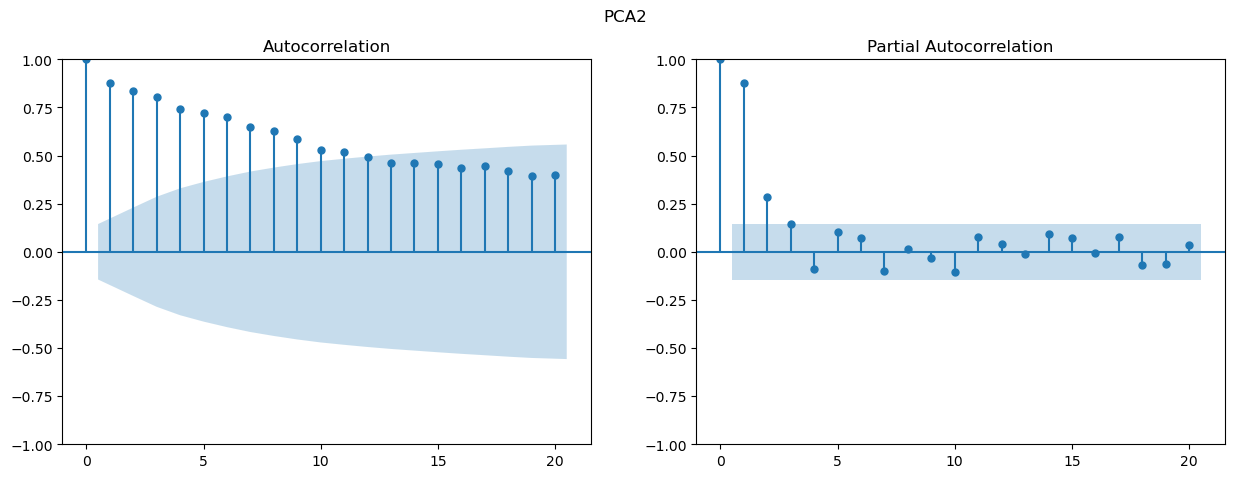

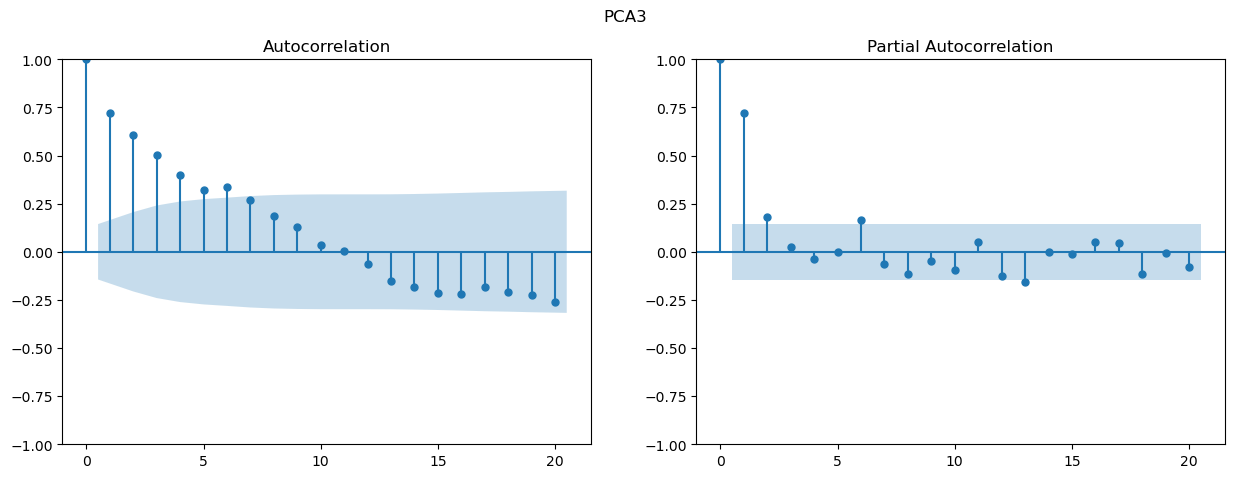

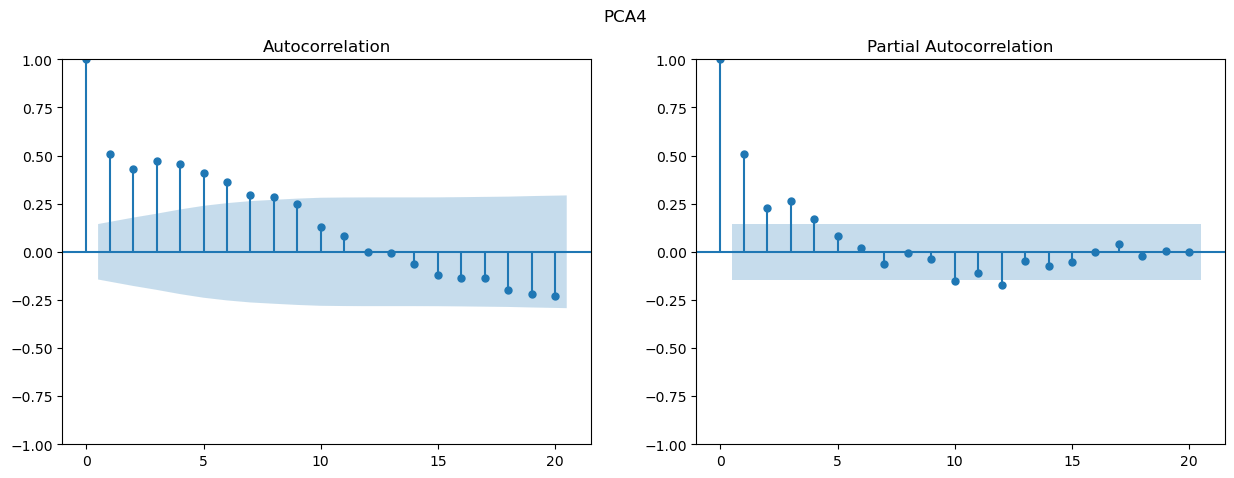

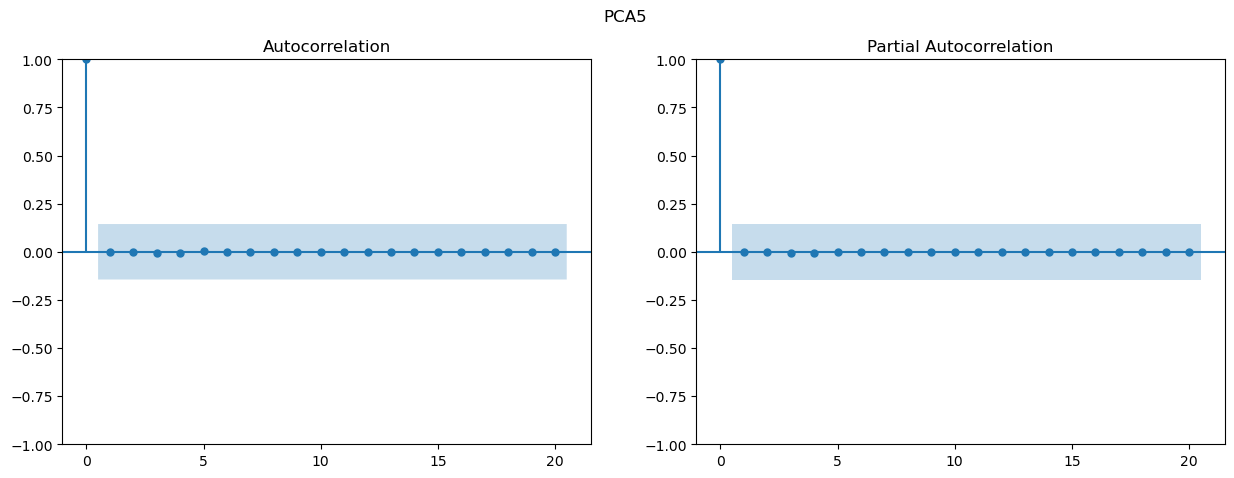

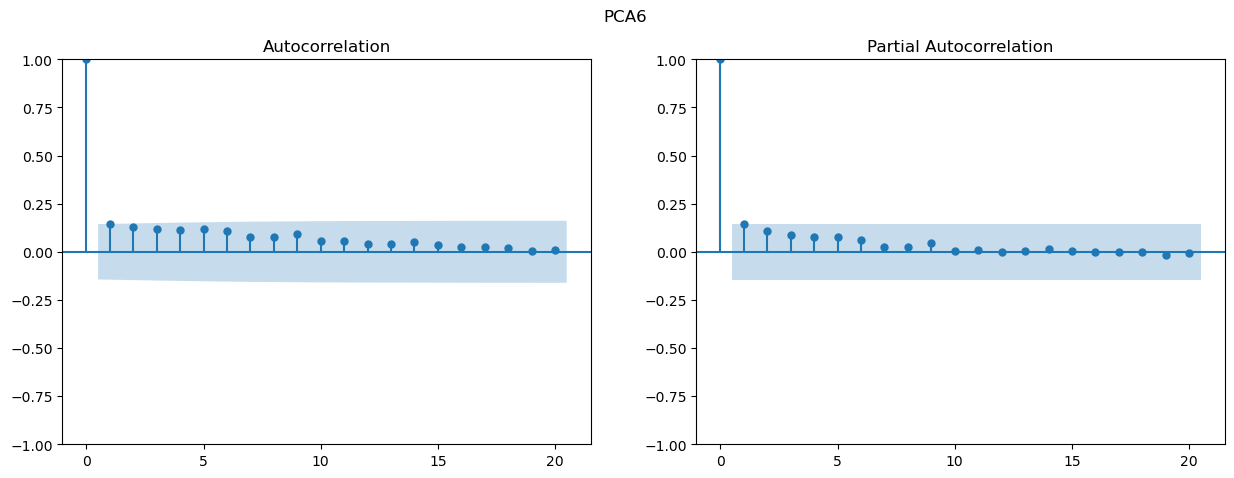

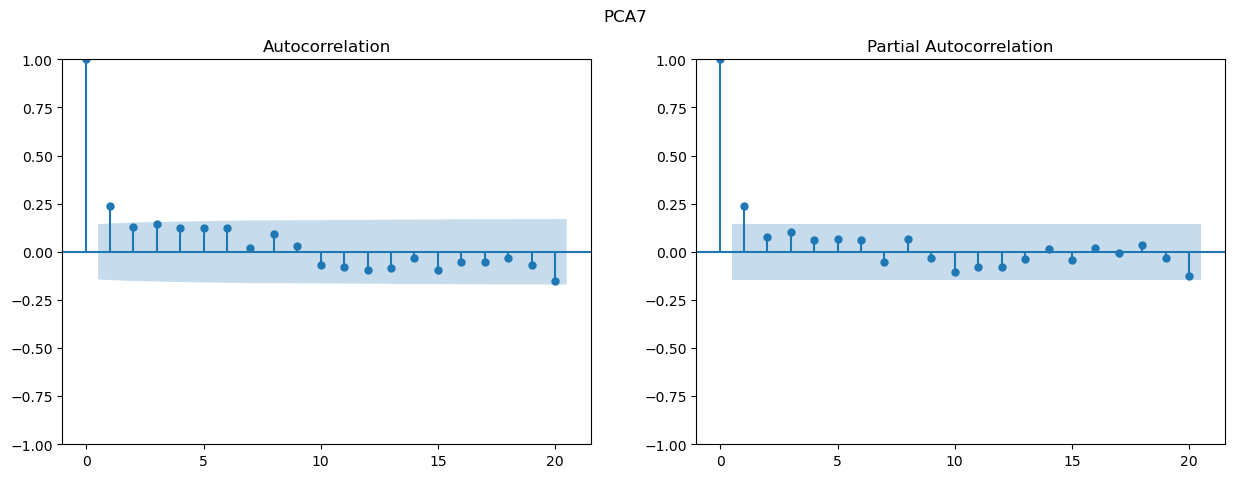

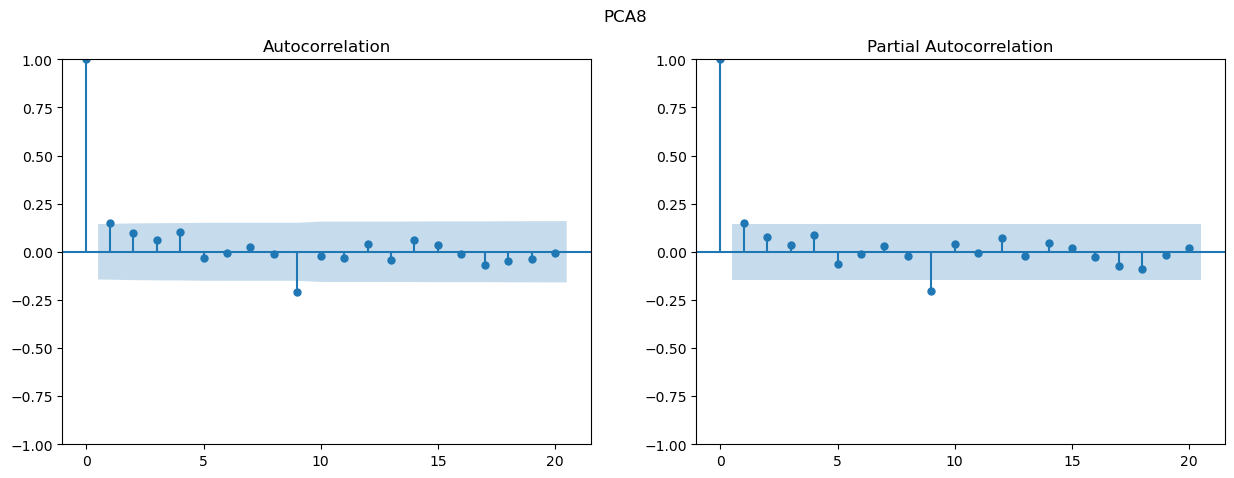

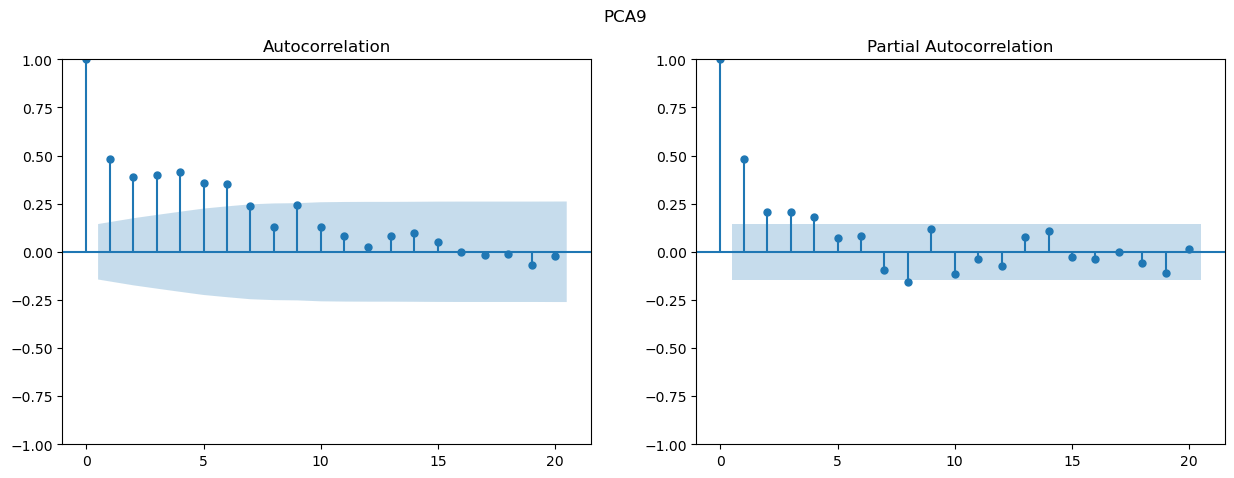

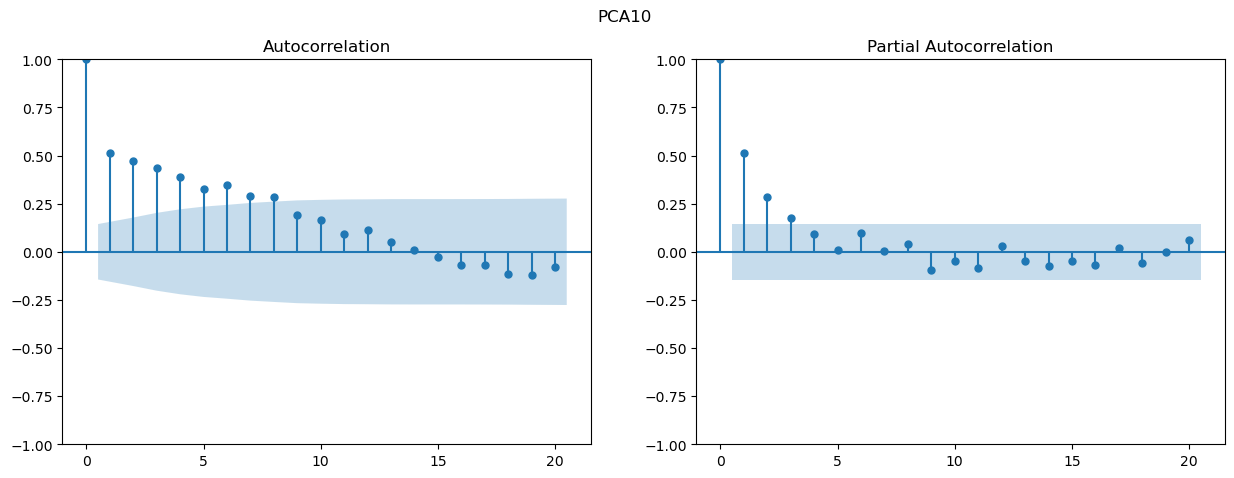

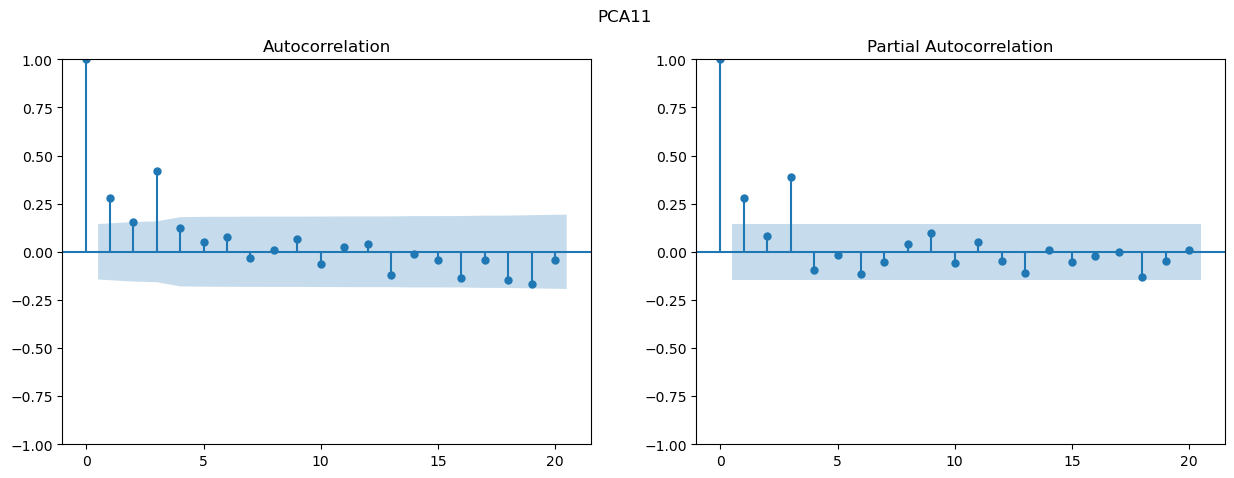

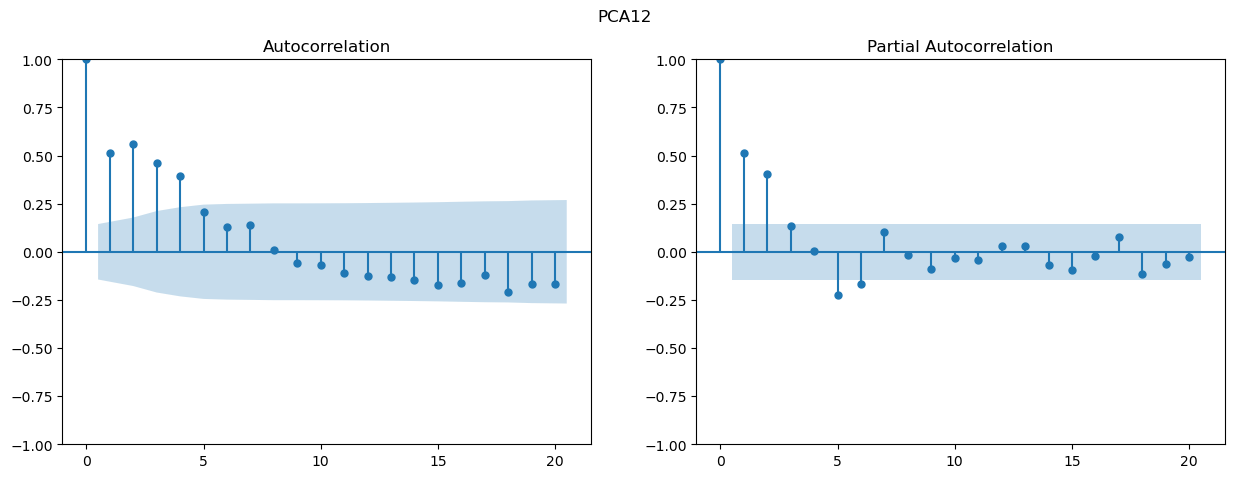

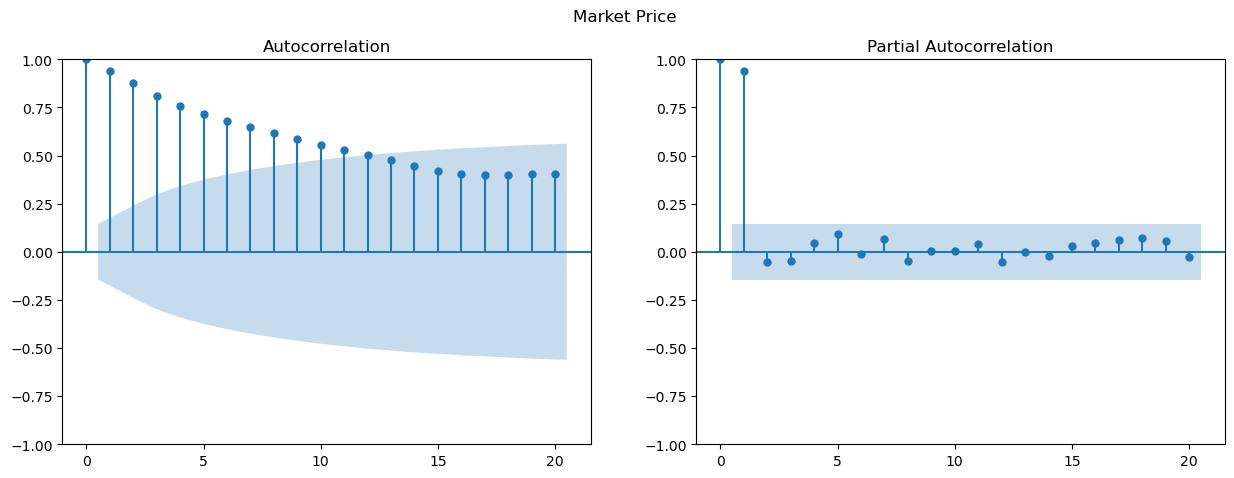

In [17]:
for col in monthly_pca_bitcoin_df.columns:
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5))
    plot_acf(monthly_pca_bitcoin_df[col], lags=20, alpha=0.05, ax=ax1)
    plot_pacf(monthly_pca_bitcoin_df[col], lags=20, alpha=0.05, ax=ax2)
    plt.suptitle(col)

In [18]:
for col in monthly_pca_bitcoin_df.columns:
    results = adfuller(monthly_pca_bitcoin_df[col])
    print(f'{col}: {results[1]}')

PCA1: 0.9954451309698801
PCA2: 0.6542293613635665
PCA3: 0.0009402391804554162
PCA4: 0.0014578877531899366
PCA5: 1.3038107021306502e-07
PCA6: 0.001008354757812923
PCA7: 1.9894343520709487e-07
PCA8: 2.3308745181026326e-21
PCA9: 0.0341814748935481
PCA10: 0.025462673002545264
PCA11: 0.0012304178228907323
PCA12: 0.0001231541701380653
Market Price: 0.9497434815733111


As per the adfuller test: PCA's _1, 2, 6_ and _Market Price_ are non-stationary whilst the rest are comfortably below our p-values indicating their usefulness for modeling.

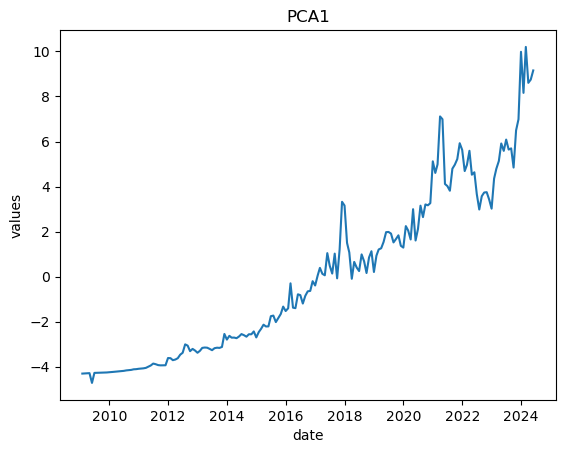

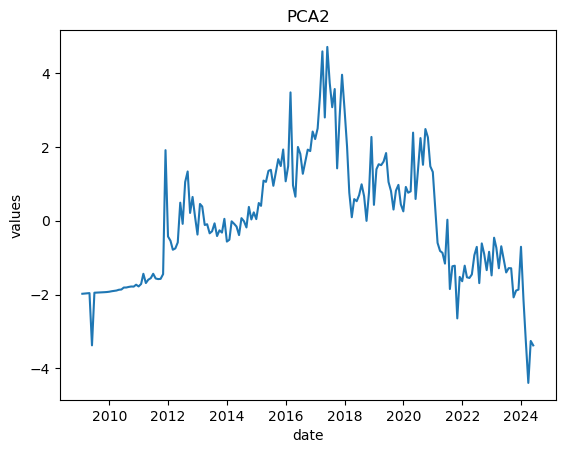

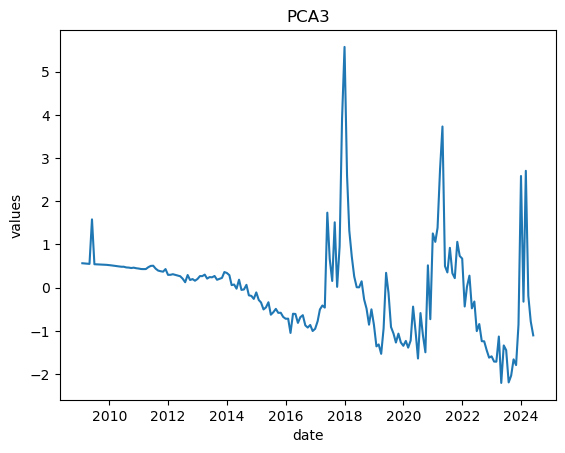

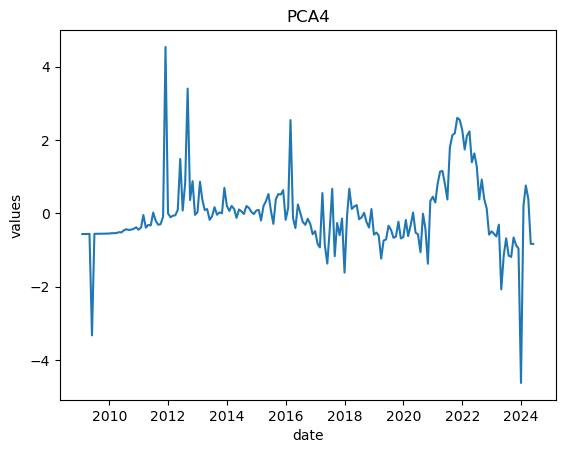

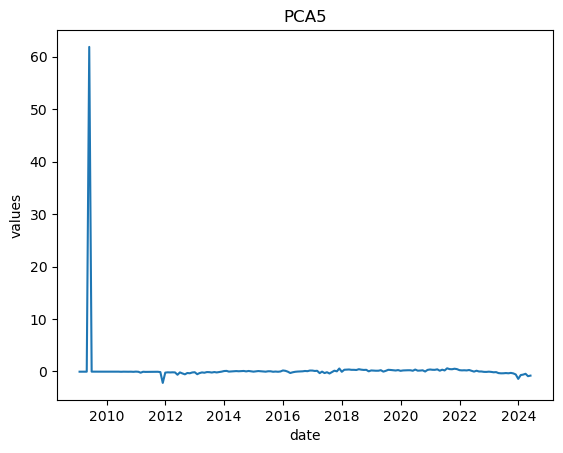

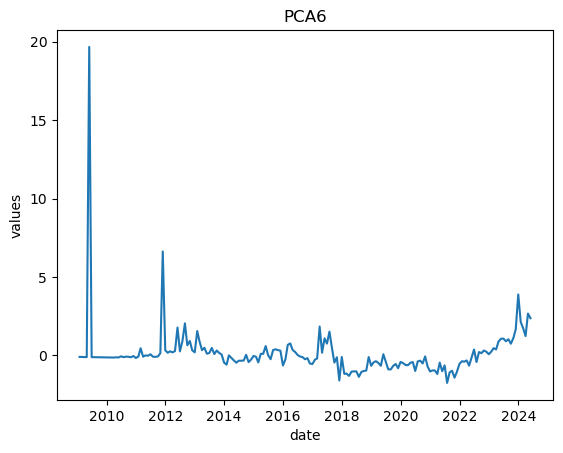

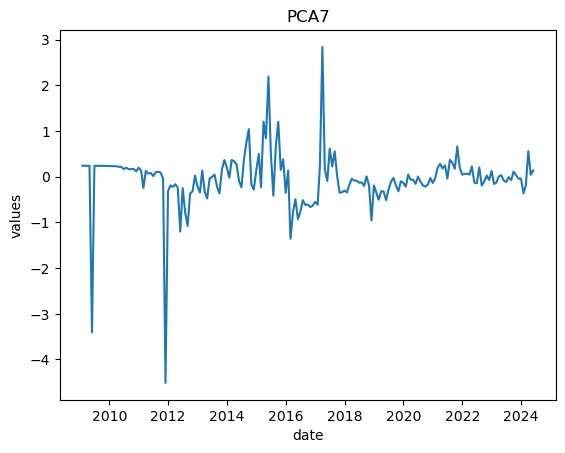

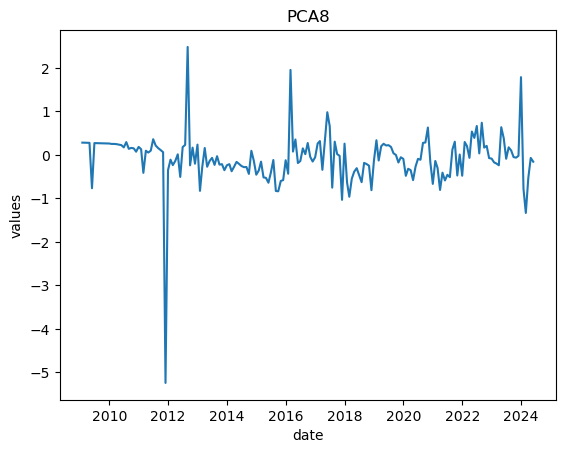

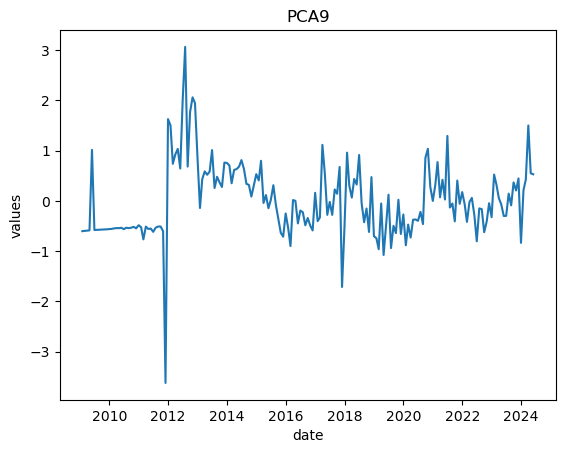

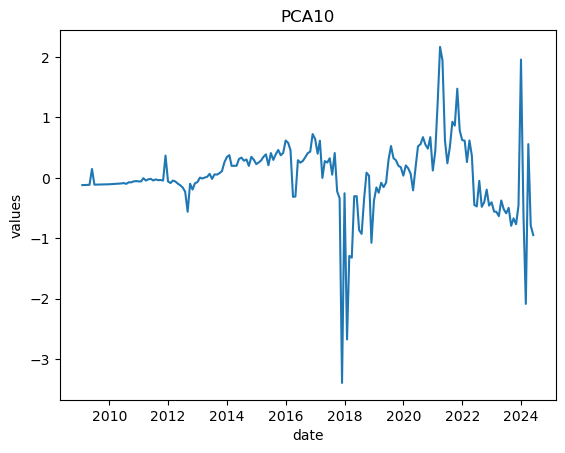

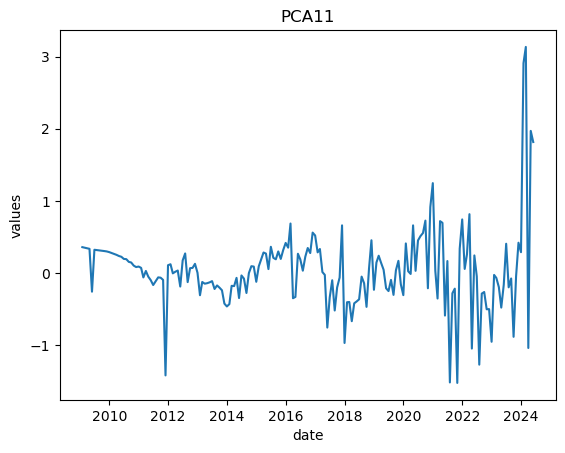

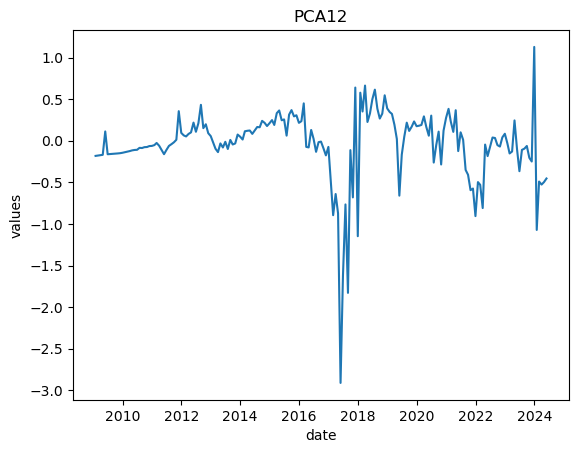

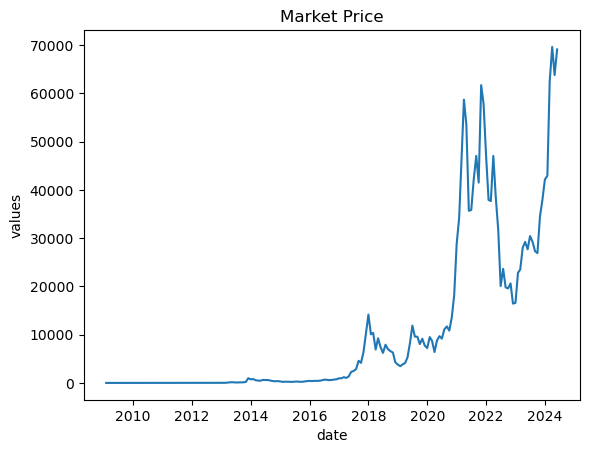

In [19]:
for feature in monthly_pca_bitcoin_df.columns:
    sns.lineplot(monthly_pca_bitcoin_df[feature])
    plt.title(feature)
    plt.xlabel('date')
    plt.ylabel('values')
    plt.show()
    plt.close()

/home/mvanslyke/mambaforge/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


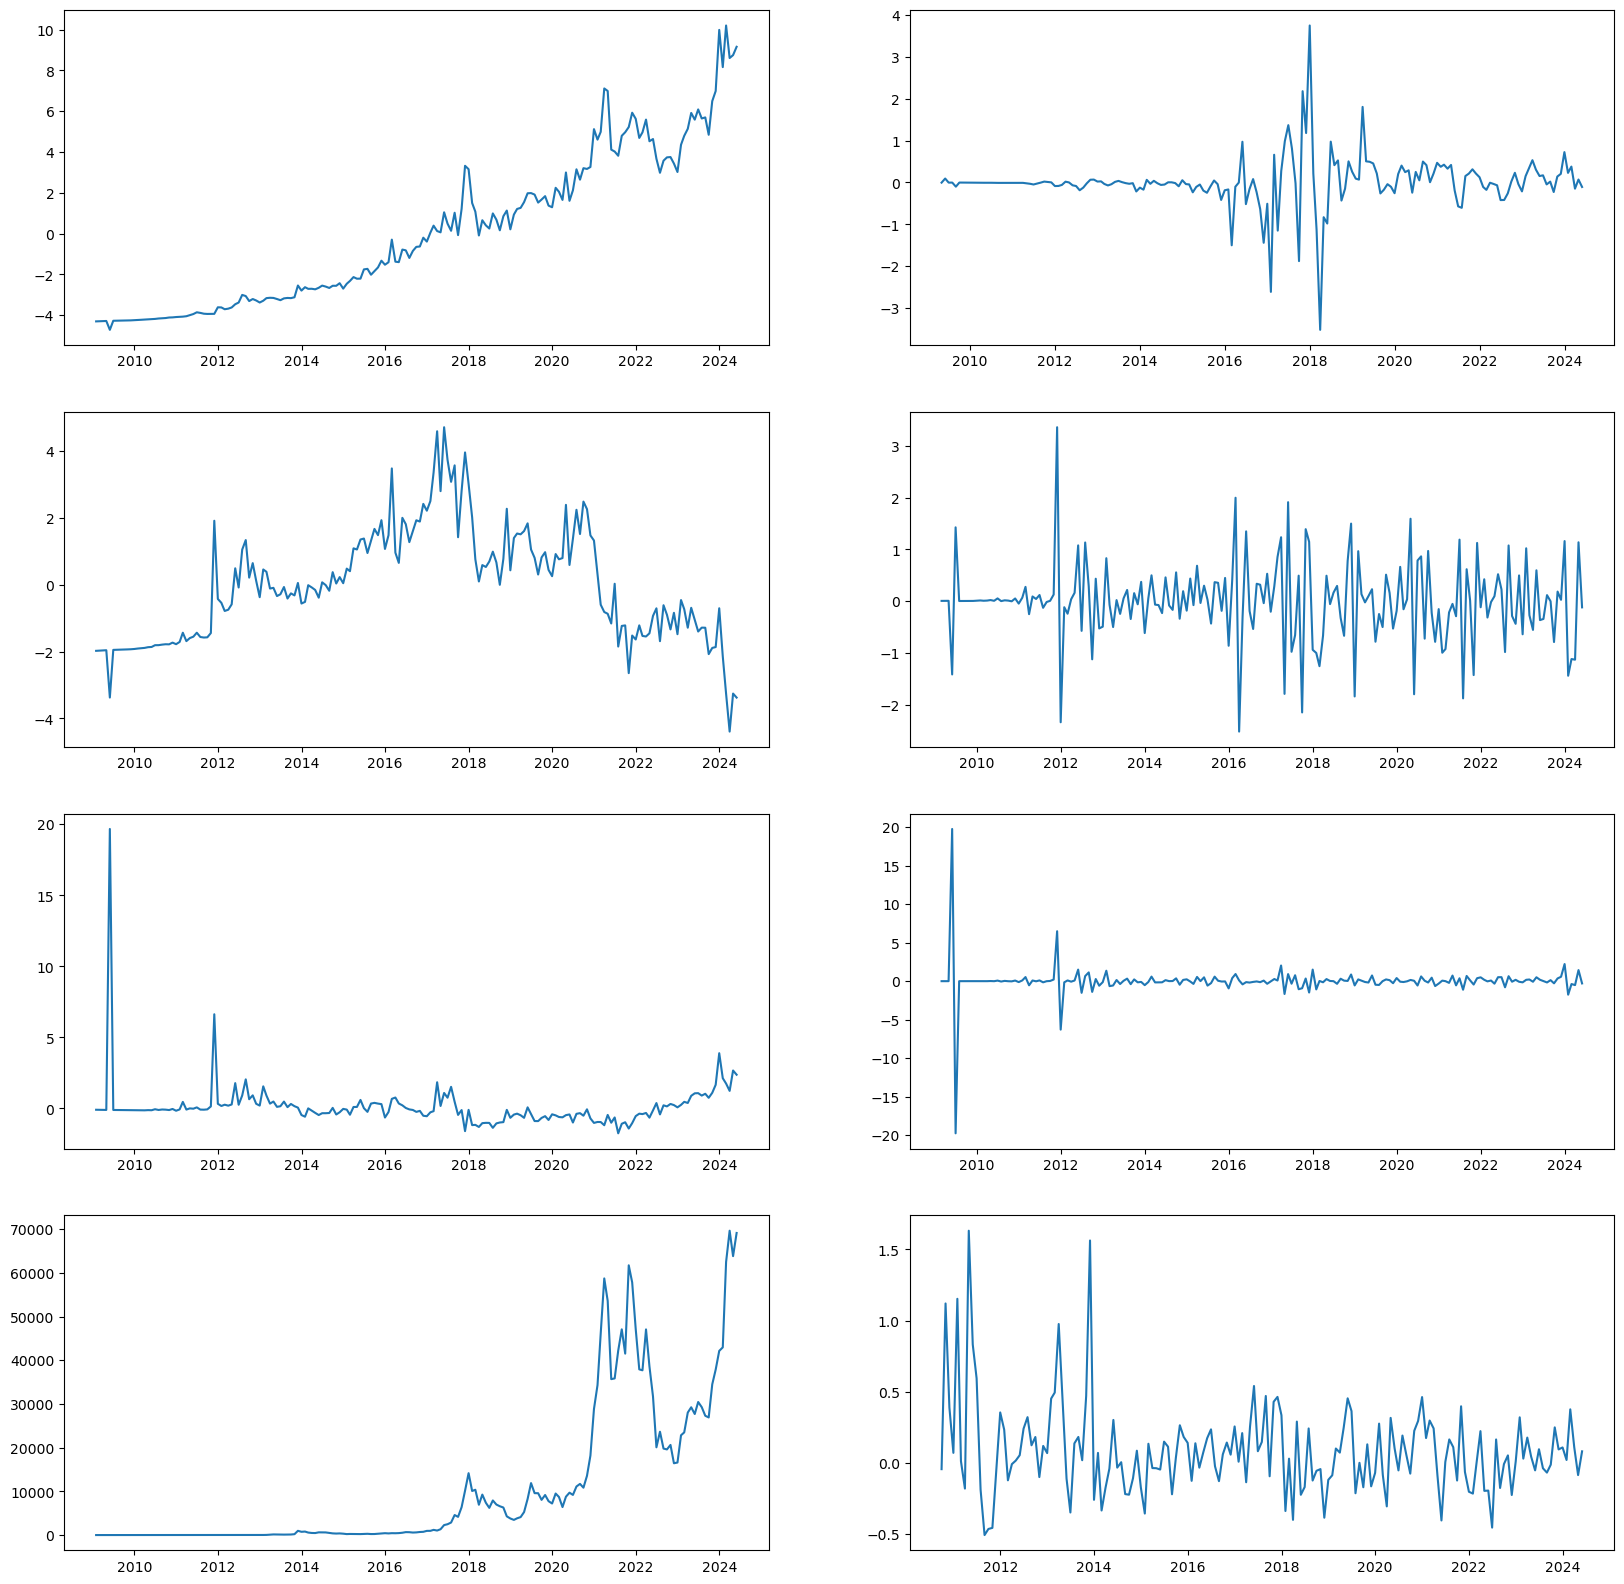

In [20]:
fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(20,20))

ax[0][0].plot(monthly_pca_bitcoin_df['PCA1'])
ax[0][1].plot(np.log(abs(monthly_pca_bitcoin_df['PCA1'])).diff(3))

ax[1][0].plot(monthly_pca_bitcoin_df['PCA2'])
ax[1][1].plot(monthly_pca_bitcoin_df['PCA2'].diff())

ax[2][0].plot(monthly_pca_bitcoin_df['PCA6'])
ax[2][1].plot(monthly_pca_bitcoin_df['PCA6'].diff())

ax[3][0].plot(monthly_pca_bitcoin_df['Market Price'])
ax[3][1].plot(np.log(abs(monthly_pca_bitcoin_df['Market Price'])).diff())

In [21]:
np.log(abs(monthly_pca_bitcoin_df['PCA1'])).diff()

date
2009-01-31         NaN
2009-02-28   -0.001506
2009-03-31   -0.001583
2009-04-30   -0.001573
2009-05-31    0.096609
                ...   
2024-01-31   -0.201744
2024-02-29    0.223171
2024-03-31   -0.170027
2024-04-30    0.016411
2024-05-31    0.045632
Freq: ME, Name: PCA1, Length: 185, dtype: float64

That should take care of our Transformations necessary for our Models so let's save these transforms into our *monthly_pca_bitcoin_df* and proceed to our preprocessing phase.

In [22]:
for pc in ['PCA1', 'PCA2', 'PCA6', 'Market Price']:
    if pc == 'PCA1':
        monthly_pca_bitcoin_df[f'{pc}_stationary'] = np.log(abs(monthly_pca_bitcoin_df['PCA1'])).diff(3)
    elif pc == 'Market Price':
       monthly_pca_bitcoin_df[f'{pc}_stationary'] = np.log(abs(monthly_pca_bitcoin_df['Market Price'])).diff()
    else:
        monthly_pca_bitcoin_df[f'{pc}_stationary'] = monthly_pca_bitcoin_df[pc].diff()

/tmp/ipykernel_3781/37240690.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_pca_bitcoin_df[f'{pc}_stationary'] = np.log(abs(monthly_pca_bitcoin_df['PCA1'])).diff(3)
/tmp/ipykernel_3781/37240690.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_pca_bitcoin_df[f'{pc}_stationary'] = monthly_pca_bitcoin_df[pc].diff()
/tmp/ipykernel_3781/37240690.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [23]:
monthly_pca_bitcoin_df.dropna(inplace=True)

/tmp/ipykernel_3781/1539485645.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_pca_bitcoin_df.dropna(inplace=True)


In [24]:
monthly_pca_bitcoin_df.drop(index='2010-08-31', inplace=True)

/tmp/ipykernel_3781/96756979.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_pca_bitcoin_df.drop(index='2010-08-31', inplace=True)


In [25]:
for col in monthly_pca_bitcoin_df.columns:
    if col == 'PCA1' or col == 'PCA2' or col == 'PCA6' or col == 'Market Price':
        continue
    else:
        results = adfuller(monthly_pca_bitcoin_df[col])
        print(f'{col}: {results[1]}')

PCA3: 0.001567956507575647
PCA4: 0.0012608472759733753
PCA5: 0.8274713608287665
PCA7: 6.612713396672285e-06
PCA8: 7.296337033410815e-06
PCA9: 0.02184508586620131
PCA10: 0.007307720670936439
PCA11: 0.0026589907374737205
PCA12: 0.0003430895322202505
PCA1_stationary: 1.434361407703436e-17
PCA2_stationary: 1.8600001234191835e-25
PCA6_stationary: 2.1105619769134943e-15
Market Price_stationary: 2.2570470620970158e-06


All of our features are now sufficiently stationary for the Analysis.

***
##### Pre-Processing
***
- Separate into _X_ and _y_ and create _train_, _test_ and/or _validate_ data sets


In [26]:
X_prime = monthly_pca_bitcoin_df[['PCA1_stationary', 'PCA2_stationary', 'PCA3', 'PCA4',
                                  'PCA5', 'PCA6_stationary', 'PCA7', 'PCA8', 'PCA9',
                                  'PCA10', 'PCA11', 'PCA12', 'Market Price_stationary']].rename(columns={'PCA1_stationary': 'PCA1',
                                                                                                         'PCA2_stationary': 'PCA2', 
                                                                                                         'PCA6_stationary': 'PCA6',
                                                                                                         'Market Price_stationary': 'Market Price'})

In [29]:
X_prime.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,Market Price
date,,,,,,,,,,,,,
2010-09-30,-0.010336,0.010967,0.454551,-0.442915,-0.062848,-0.010012,0.165154,0.161381,-0.533707,-0.075476,0.144298,-0.077008,-0.045713
2010-10-31,-0.011741,-0.002829,0.463001,-0.421634,-0.054172,-0.028095,0.171544,0.151653,-0.517539,-0.059395,0.101462,-0.075337,1.119890
2010-11-30,-0.010639,0.051903,0.450317,-0.378658,-0.079583,0.076035,0.115946,0.074011,-0.546958,-0.053924,0.081190,-0.063967,0.387766
2010-12-31,-0.011938,-0.047017,0.442663,-0.445379,-0.039219,-0.124594,0.196844,0.184849,-0.484988,-0.059855,0.088238,-0.062100,0.068993
2011-01-31,-0.007806,0.066603,0.431579,-0.381060,-0.068381,0.092782,0.133499,0.131493,-0.524707,-0.060113,0.069921,-0.052373,1.152680


- ##### ARIMA MODELS #####
***

In [28]:
# Univariate Model data
X_univar = X_prime['Market Price']

X_train = X_univar[:int(len(X_univar) * 0.8)]
X_test = X_univar[int(len(X_univar) * 0.8):]

In [29]:
def ARIMA_model_selector(X, pval=3, dval=3, qval=3):
    '''Takes a univarate dataset and p, d, q parameters for an ARIMA model
    and fits, measures, and visualizes the resultant data. selects the best scores
    from both the AIC and BIC metrics and takes their full diagnostic for suitability
    returns metrics_df for further diagnostics if the lowest AIC/BIC scores are not suitable'''
    # Test Models
    model_metrics = {'AIC': {}, 'BIC': {}, 'pdq': {}}
    best_models = {'AIC': None, 'BIC': None}

    for d in range(dval):
        for p in range(pval):
            for q in range(qval):
                try:
                    model = ARIMA(X, order=(p,d,q))
                    results = model.fit()

                    model_metrics['AIC'][f'ARIMA({p},{d},{q})'] = results.aic
                    model_metrics['BIC'][f'ARIMA({p},{d},{q})'] = results.bic
                    model_metrics['pdq'][f'ARIMA({p},{d},{q})'] = (p,d,q)

                    if best_models['AIC'] == None and best_models['BIC'] == None:
                        best_models['AIC'] = [model, results]
                        best_models['BIC'] = [model, results]

                    elif best_models['AIC'][1].aic > results.aic and best_models['BIC'][1].bic > results.bic:
                        best_models['AIC'] = [model, results]
                        best_models['BIC'] = [model, results]
                        print('\nUpdated ARIMA aic and bic selection:')
                        print(f'order: ({p}, {d}, {q}) aic-score: {results.aic} bic-score:{results.bic}')

                    elif best_models['AIC'][1].aic > results.aic and best_models['BIC'][1].bic < results.bic:
                        best_models['AIC'] = [model, results]
                        print('\nUpdated ARIMA aic selection:')
                        print(f'order: ({p}, {d}, {q}) score: {results.aic}')

                    elif best_models['BIC'][1].bic > results.bic and best_models['AIC'][1].aic < results.aic:
                        best_models['BIC'] = [model, results]
                        print('\nUpdated ARIMA bic selection:')
                        print(f'order: ({p}, {d}, {q}) score: {results.bic}')

                    else:
                        print(p, d, q, results.aic, results.bic)

                except:
                    print(p, d, q, None, None)
    # Visualize AIC vs BIC scores            
    metrics_df = pd.DataFrame(model_metrics)

    plt.plot(metrics_df['AIC'], label='AIC')
    plt.plot(metrics_df['BIC'], label='BIC')
    plt.legend()
    plt.title('Model Fit Metrics')
    plt.xlabel('Models')
    plt.xticks(rotation=90)
    plt.ylabel('Scores')
    plt.show()

    # Select lowest scores from AIC and BIC and then pull their Summary and visualize their full metrics.
    for key in best_models:
        best_models[key][1].plot_diagnostics()
        print(best_models[key][1].summary())
    
    return metrics_df, best_models


Updated ARIMA aic and bic selection:
order: (0, 0, 1) aic-score: 85.87607075312972 bic-score:95.19390717483147


0 0 2 87.875952672196 100.29973456779831
1 0 0 85.9115289768137 95.22936539851544
1 0 1 87.87530053372319 100.29908242932551
1 0 2 89.64934920701243 105.17907657651534
2 0 0 87.90473314000118 100.3285150356035


/home/mvanslyke/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/mvanslyke/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/mvanslyke/mambaforge/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 0 1 89.51194514262212 105.04167251212502
2 0 2 91.15451618636303 109.79018902976651
0 1 0 161.61264148555048 164.71250791337468
0 1 1 95.39394751705626 101.59368037270465
0 1 2 90.00702244514434 99.30662172861693
1 1 0 137.32376749667287 143.52350035232126
1 1 1 90.17452421105986 99.47412349453245
1 1 2 91.95520260340798 104.35466831470478
2 1 0 120.05234405022202 129.3519433336946
2 1 1 92.14138407838155 104.54084978967835
2 1 2 93.68723352393037 109.18656566305137


/home/mvanslyke/mambaforge/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/mvanslyke/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


0 2 0 323.299481674168 326.3932318749748
0 2 1 168.73918523792156 174.9266856395351
0 2 2 107.52061148871724 116.80186209113752
1 2 0 258.95415434702437 265.1416547486379
1 2 1 145.2637188235692 154.5449694259895
1 2 2 101.40732622025634 113.78232702348339
2 2 0 205.1775489055634 214.4587995079837
2 2 1 128.669972223663 141.04497302689003


/home/mvanslyke/mambaforge/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 2 2 103.40232492681773 118.87107593085153


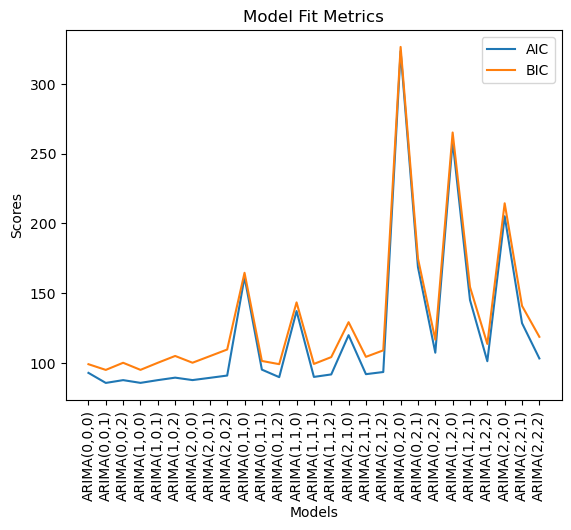

                               SARIMAX Results                                
Dep. Variable:           Market Price   No. Observations:                  165
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -39.938
Date:                Wed, 29 May 2024   AIC                             85.876
Time:                        04:14:23   BIC                             95.194
Sample:                    09-30-2010   HQIC                            89.659
                         - 05-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0836      0.038      2.178      0.029       0.008       0.159
ma.L1          0.2394      0.067      3.567      0.000       0.108       0.371
sigma2         0.0950      0.006     15.053      0.0

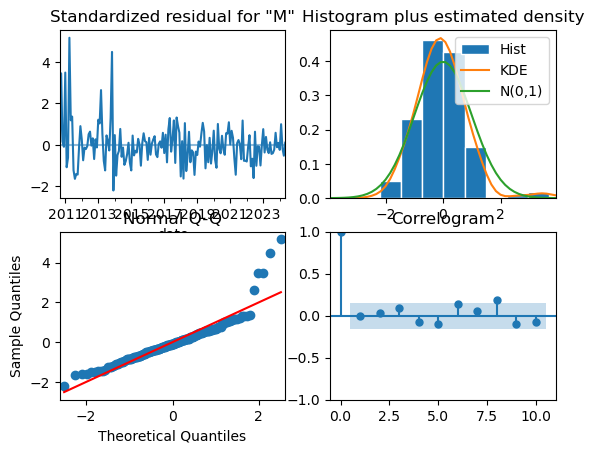

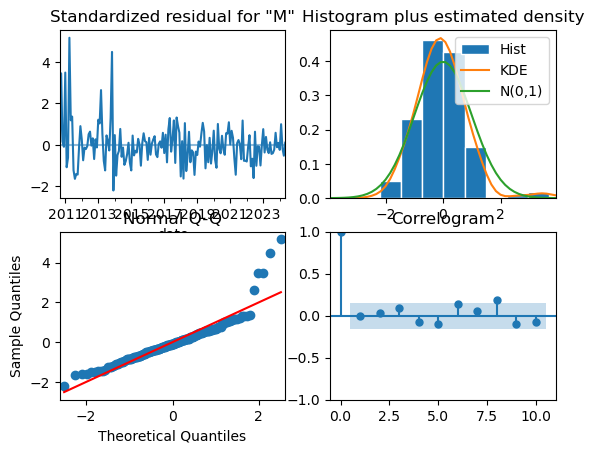

In [30]:
metrics_df, best_models = ARIMA_model_selector(X_univar)

These results concur from both the AIC and BIC scores that an ARIMA(0,0,1) or MA model would work best for this univariate series. the summary in the Prob(Q) confirms that residuals are definitely uncorrelated, our theoretical quantiles are reasonabley close to the linear regression and almost all points fall within the confidence area of the correlogram.  So without very little doubt as to the this being the best univariate ARIMA (MA) Model we could do.

In [31]:
def convert_statpred_to_origpred(stationary_predictions, original_data):
  """Converts stationary predictions to original predictions.

  Args:
    stationary_predictions: A NumPy array of stationary predictions.
    original_data: A NumPy array of original data.

  Returns:
    A NumPy array of original predictions.
  """

  # Calculate the cumulative sum of the stationary predictions.
  cumulative_sum = np.cumsum(stationary_predictions)

  # Add the first value of the original data to the cumulative sum.
  try:
    cumulative_sum += original_data.iloc[0]
  except:
    cumulative_sum += original_data[0]

  # Calculate the original predictions by taking the exponential of the cumulative sum.
  original_predictions = np.exp(cumulative_sum)

  return original_predictions

In [32]:
ARIMA_model, ARIMA_results = best_models['AIC']

In [33]:
ARIMA_predictions = ARIMA_results.get_prediction(start=0)
ARIMA_predictions_orig = convert_statpred_to_origpred(ARIMA_predictions.predicted_mean[-len(X_test):], X_test)

In [34]:
ARIMA_predictionsci = ARIMA_predictions.conf_int()

In [35]:
lower_ci = ARIMA_predictionsci['lower Market Price']
upper_ci = ARIMA_predictionsci['upper Market Price']

In [36]:
rmse = np.sqrt(mean_squared_error(X_test, ARIMA_predictions.predicted_mean[-len(X_test):]))
print('RMSE:', rmse)

RMSE: 0.19732524897699033


In [37]:
ARIMA_predictions_orig

date
2021-09-30    0.960784
2021-10-31    0.993141
2021-11-30    1.177944
2021-12-31    1.210360
2022-01-31    1.244951
2022-02-28    1.276229
2022-03-31    1.377478
2022-04-30    1.550695
2022-05-31    1.562825
2022-06-30    1.618114
2022-07-31    1.563951
2022-08-31    1.782638
2022-09-30    1.800017
2022-10-31    1.947904
2022-11-30    2.103809
2022-12-31    2.126575
2023-01-31    2.311732
2023-02-28    2.659171
2023-03-31    2.815020
2023-04-30    3.149450
2023-05-31    3.367338
2023-06-30    3.556546
2023-07-31    3.903848
2023-08-31    4.111882
2023-09-30    4.342192
2023-10-31    4.644013
2023-11-30    5.272804
2023-12-31    5.686478
2024-01-31    6.229475
2024-02-29    6.656626
2024-03-31    7.792633
2024-04-30    8.373194
2024-05-31    8.763441
Freq: ME, Name: predicted_mean, dtype: float64

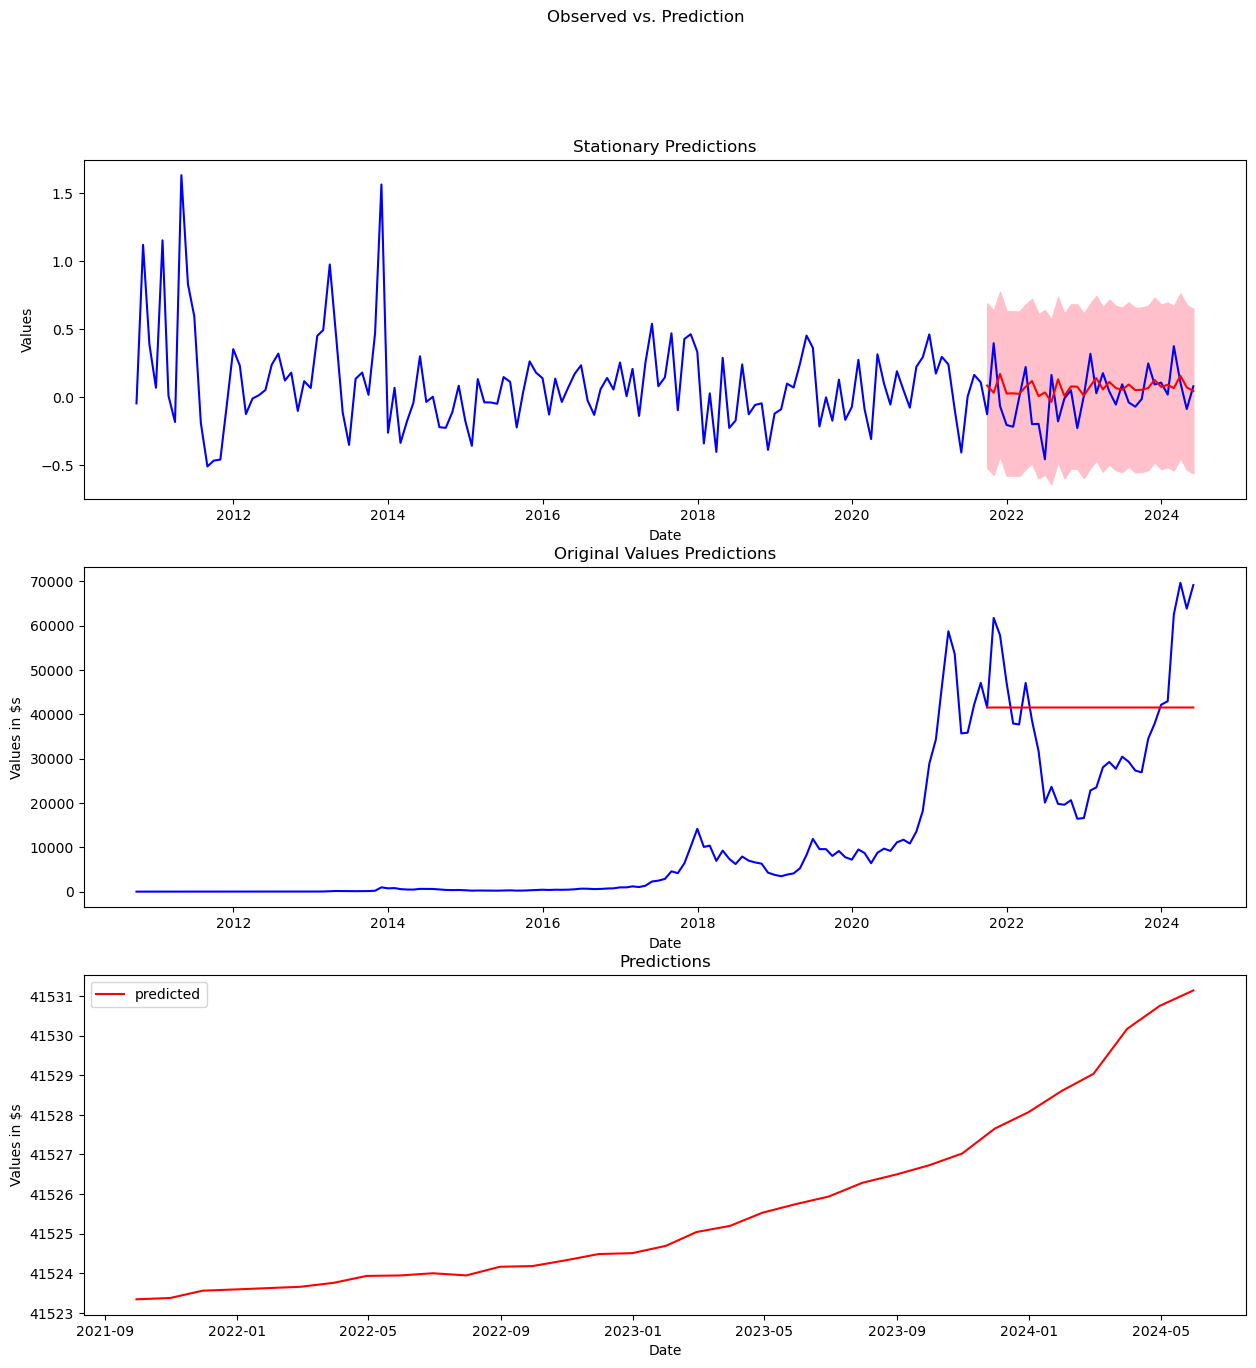

In [38]:
_, (ax1,ax2,ax3) = plt.subplots(nrows=3, figsize=(15,15))
ax1.plot(X_prime['Market Price'], label='observed', color='blue')
ax1.plot(ARIMA_predictions.predicted_mean[-len(X_test):], label='predicted', color='red')
ax1.fill_between(ARIMA_predictionsci.index[-len(X_test):], lower_ci[-len(X_test):], upper_ci[-len(X_test):], color='pink')
ax1.set_xlabel('Date')
ax1.set_ylabel('Values')
ax1.set_title('Stationary Predictions')

ax2.plot(monthly_pca_bitcoin_df['Market Price'], label='observed', color='blue')
ax2.plot((ARIMA_predictions_orig[-len(X_test):] + monthly_pca_bitcoin_df['Market Price'].iloc[int(len(X_univar) * 0.8)]), label='predicted', color='red')
ax2.set_xlabel('Date')
ax2.set_ylabel('Values in $s')
ax2.set_title('Original Values Predictions')

ax3.plot((ARIMA_predictions_orig[-len(X_test):] + monthly_pca_bitcoin_df['Market Price'].iloc[int(len(X_univar) * 0.8)]), color='red', label='predicted')
ax3.set_xlabel('Date')
ax3.set_ylabel('Values in $s')
ax3.set_title('Predictions')

plt.suptitle('Observed vs. Prediction')
plt.legend()
plt.show()

So interesting results here from the model predictions.  When left visually with the stationary time-series, the line seems to move to predict what the next value problably is, when including the area included within the Confidence interval range, the true values all fall within this confidence interval, which is a good thing.  However when we return the Time series to their original values and transform the predictions to match, it looks just like a straight line. and when we look closer it appears to be a very low exponential curve happening here.  There is a very broad degree of variability happening which a simple univariate model won't be able to capture it seems so thus, we will try an LSTM model next and see if it performs any better.

- ##### LSTM MODELS #####
***

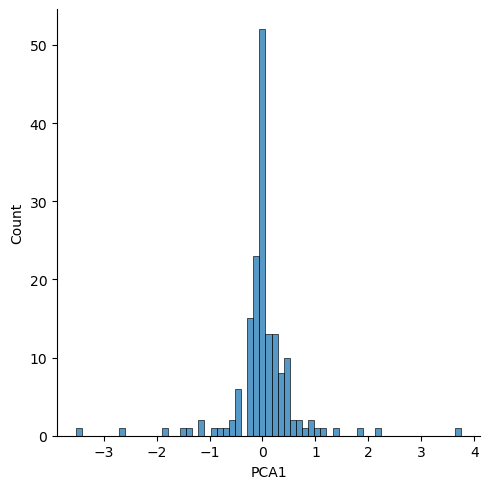

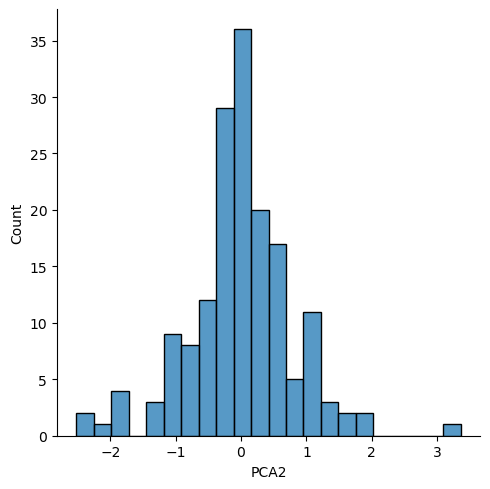

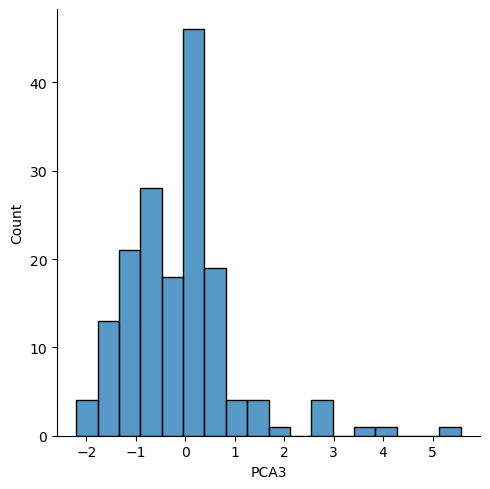

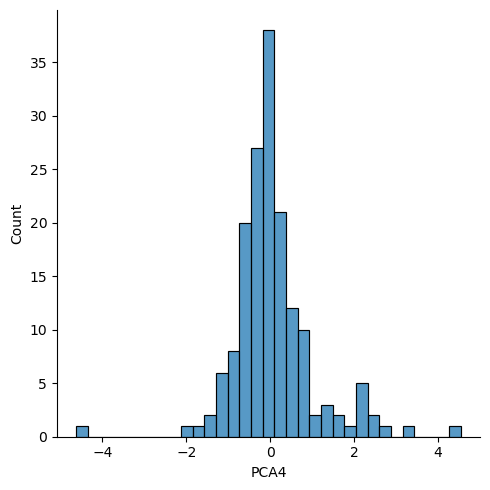

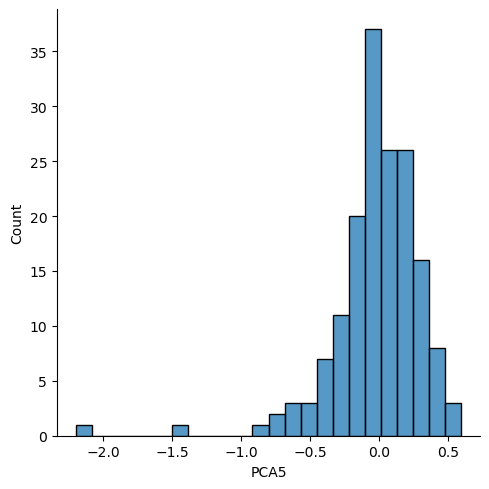

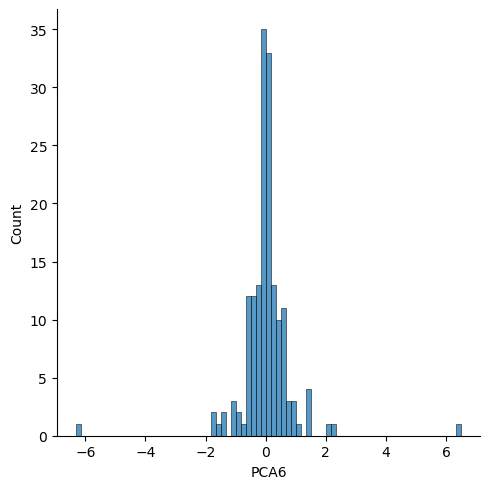

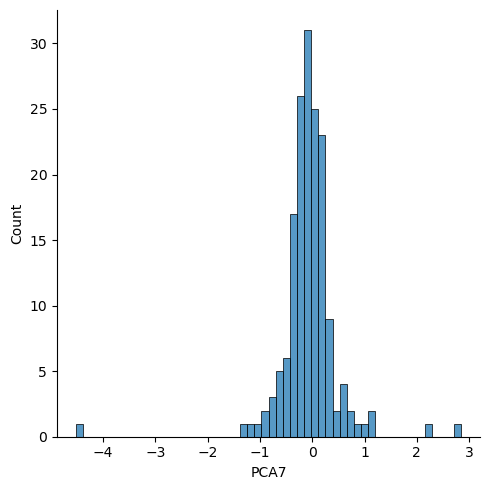

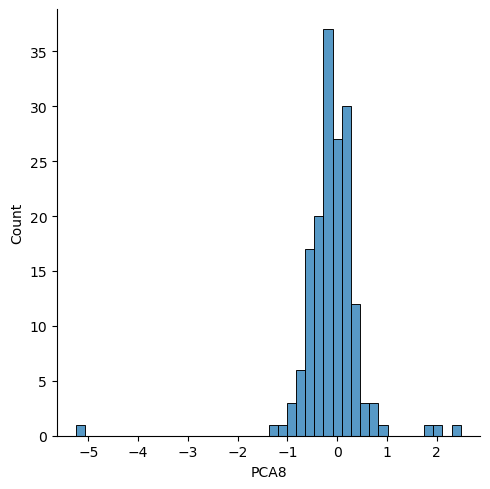

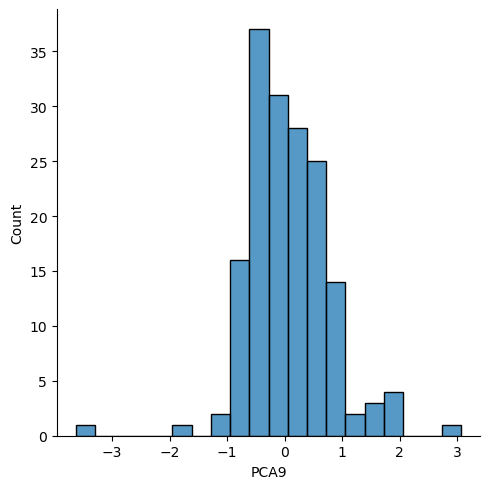

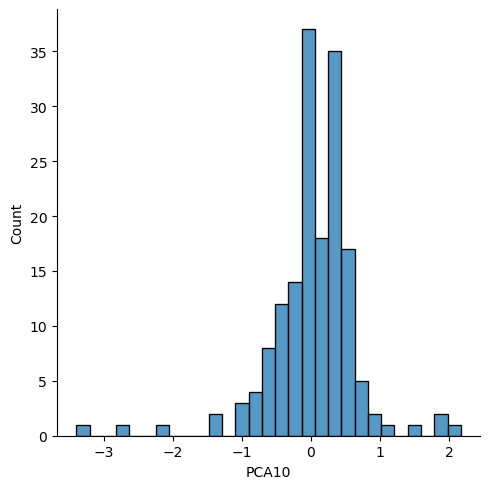

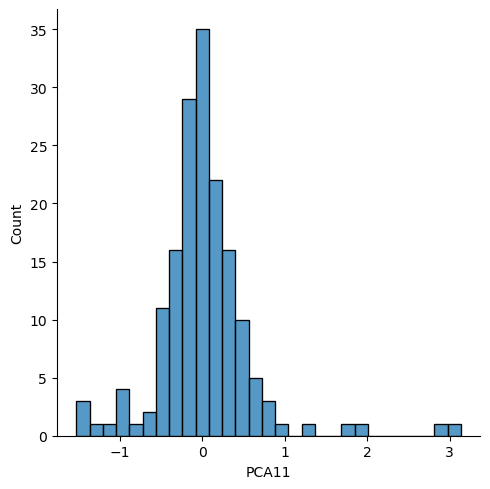

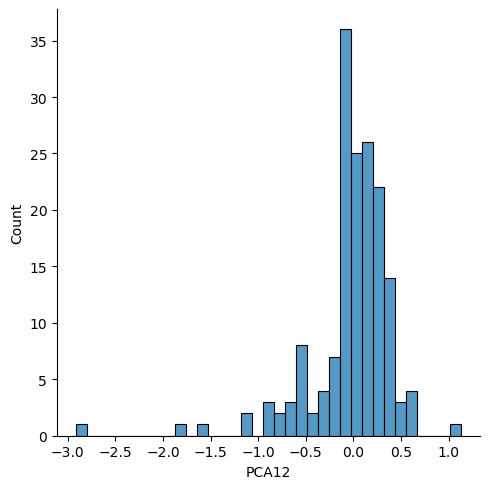

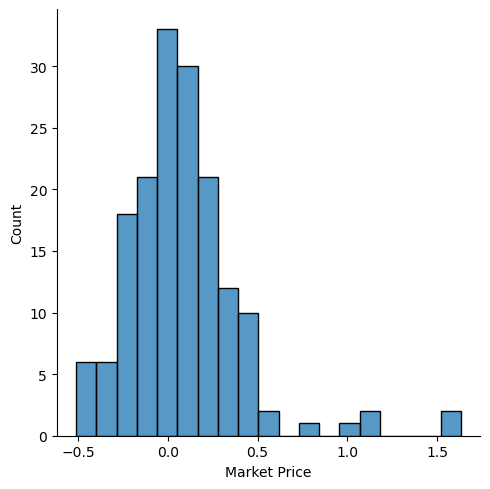

In [39]:
for col in X_prime.columns:
    sns.displot(X_prime[col])

Good news! data is fairly normally distributed with a few outliers, so without further ado, we are good to continue creating our LSTM, Also it turns out the LSTM Models don't require stationary data so we will create a new LSTM_prime variabel which has the original data from the initially imported DataFrames

In [40]:
monthly_pca_bitcoin_df.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,Market Price,PCA1_stationary,PCA2_stationary,PCA6_stationary,Market Price_stationary
date,,,,,,,,,,,,,,,,,
2010-09-30,-4.139563,-1.782462,0.454551,-0.442915,-0.062848,-0.082861,0.165154,0.161381,-0.533707,-0.075476,0.144298,-0.077008,0.062,-0.010336,0.010967,-0.010012,-0.045713
2010-10-31,-4.113286,-1.785291,0.463001,-0.421634,-0.054172,-0.110956,0.171544,0.151653,-0.517539,-0.059395,0.101462,-0.075337,0.190,-0.011741,-0.002829,-0.028095,1.119890
2010-11-30,-4.107214,-1.733388,0.450317,-0.378658,-0.079583,-0.034921,0.115946,0.074011,-0.546958,-0.053924,0.081190,-0.063967,0.280,-0.010639,0.051903,0.076035,0.387766
2010-12-31,-4.090439,-1.780404,0.442663,-0.445379,-0.039219,-0.159515,0.196844,0.184849,-0.484988,-0.059855,0.088238,-0.062100,0.300,-0.011938,-0.047017,-0.124594,0.068993
2011-01-31,-4.081305,-1.713802,0.431579,-0.381060,-0.068381,-0.066733,0.133499,0.131493,-0.524707,-0.060113,0.069921,-0.052373,0.950,-0.007806,0.066603,0.092782,1.152680


In [41]:
monthly_pca_bitcoin_df.columns[:13]

Index(['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9',
       'PCA10', 'PCA11', 'PCA12', 'Market Price'],
      dtype='object')

In [42]:
scaler = MinMaxScaler()

LSTM_X_prime = scaler.fit_transform(monthly_pca_bitcoin_df[monthly_pca_bitcoin_df.columns[:13]])

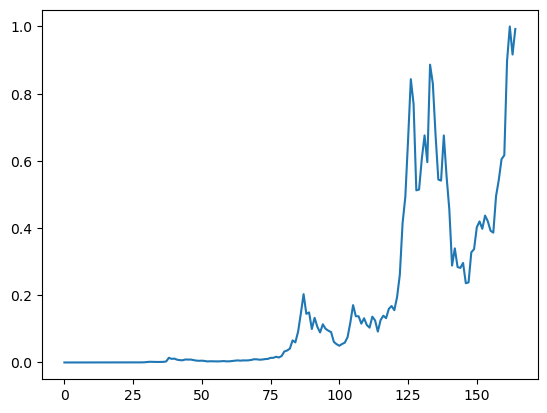

In [43]:
plt.plot(LSTM_X_prime[:,12])

In [44]:
#########################
# LSTM MODELING FUNCTIONS
#########################
def to_X_y(array, window=5):
    #array = df.to_numpy()
    X = []
    y = []
    for i in range(len(array) - window):
        row = [k[:len(k)] for k in array[i: i + window,: -1]]
        X.append(row)
        label = array[i + window, -1]
        y.append(label)
        
    return np.array(X), np.array(y)


def train_test_val_split(X, y, train_length=0.75, val_length=0.15, test_length=0.10):
    # X, y train
    X_train, y_train = X[:int(round(len(X) * train_length))], y[:int(round(len(y) * train_length))]
    
    # X, y val
    X_val, y_val = X[:int(round(len(X) * val_length))], y[:int(round(len(y) * val_length))]
    
    # X, y test
    X_test, y_test = X[:int(round(len(X) * test_length))], y[:int(round(len(y) * test_length))]
    
    return X_train, y_train, X_val, y_val, X_test, y_test


def df_convert_pred(source_series, predictions):
    '''predictions must be completed all the way until the end,
        no middle predictions yet!'''
    div_value = len(source_series) - len(predictions)
    fill_list = []

    for i in range(div_value):
        fill_list.append(np.NaN)

    new_pred = np.concatenate([np.array(fill_list), predictions])

    return pd.DataFrame({'Observed': source_series, 'Predictions': new_pred})
    
    
def results_original_scale(source_array, predictions, scaler, index, window=5):
    '''
    a function for restoring observed and predicted data to original scale prior to visualizing.
    the predictions variable needs to have DateTime as its index
    '''
    # create a temp_array for both reverse transformations for predictions and observed data.
    temp_array = copy.copy(source_array)
    
    # Concatenate all Dfs
    results_df = df_convert_pred(source_array[:,12], predictions).set_index(index)

    # Assign the predictions to temp_array
    temp_array[:,12] = results_df['Predictions']

    # inverse_transform predictions and observed data.
    predicted = scaler.inverse_transform(temp_array)[window:, 12]
    observed = scaler.inverse_transform(source_array)[window:, 12]

    # return the results in a DataFrame
    return pd.DataFrame({'Observed': observed, 'Predictions': predicted}).set_index(index[window:])

In [45]:
# Divide Data into X, y for Train, val and Test data
Window = 5
LSTM_X, LSTM_y = to_X_y(LSTM_X_prime, window=Window)
LSTM_X_train, LSTM_y_train, LSTM_X_val, LSTM_y_val, LSTM_X_test, LSTM_y_test = train_test_val_split(LSTM_X, LSTM_y)

In [46]:
print(f'Train_X: {LSTM_X_train.shape}\nTrain_y: {LSTM_y_train.shape}\nVal_X: {LSTM_X_val.shape}\nVal_y: {LSTM_y_val.shape}\nTest_X: {LSTM_X_test.shape}\nTest_y: {LSTM_y_test.shape}')

Train_X: (120, 5, 12)
Train_y: (120,)
Val_X: (24, 5, 12)
Val_y: (24,)
Test_X: (16, 5, 12)
Test_y: (16,)


Now we can proceed to build the Multivariate LSTM Model

In [47]:
model = Sequential()
model.add(LSTM(250, input_shape=(LSTM_X_train.shape[1], LSTM_X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(12))
model.add(Dense(1))
model.compile(loss=MeanAbsoluteError(), metrics=RootMeanSquaredError(), optimizer=Adam())

In [48]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 250)               263000    
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense (Dense)               (None, 12)                3012      
                                                                 
 dense_1 (Dense)             (None, 1)                 13        
                                                                 
Total params: 266025 (1.01 MB)
Trainable params: 266025 (1.01 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
history = model.fit(LSTM_X_train,
                    LSTM_y_train,
                    epochs=250,
                    batch_size=72,
                    validation_data=(LSTM_X_val, LSTM_y_val),
                    verbose=2,
                    shuffle=False)

Epoch 1/250
2/2 - 13s - loss: 0.1145 - root_mean_squared_error: 0.1411 - val_loss: 0.2019 - val_root_mean_squared_error: 0.2021 - 13s/epoch - 7s/step
Epoch 2/250
2/2 - 0s - loss: 0.1651 - root_mean_squared_error: 0.1894 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0064 - 234ms/epoch - 117ms/step
Epoch 3/250
2/2 - 0s - loss: 0.0852 - root_mean_squared_error: 0.1285 - val_loss: 0.0074 - val_root_mean_squared_error: 0.0080 - 243ms/epoch - 121ms/step
Epoch 4/250
2/2 - 0s - loss: 0.0682 - root_mean_squared_error: 0.0949 - val_loss: 0.0826 - val_root_mean_squared_error: 0.0828 - 237ms/epoch - 119ms/step
Epoch 5/250
2/2 - 0s - loss: 0.0778 - root_mean_squared_error: 0.1012 - val_loss: 0.0812 - val_root_mean_squared_error: 0.0814 - 238ms/epoch - 119ms/step
Epoch 6/250
2/2 - 0s - loss: 0.0886 - root_mean_squared_error: 0.1081 - val_loss: 0.0097 - val_root_mean_squared_error: 0.0109 - 240ms/epoch - 120ms/step
Epoch 7/250
2/2 - 0s - loss: 0.0686 - root_mean_squared_error: 0.0984 - val_loss

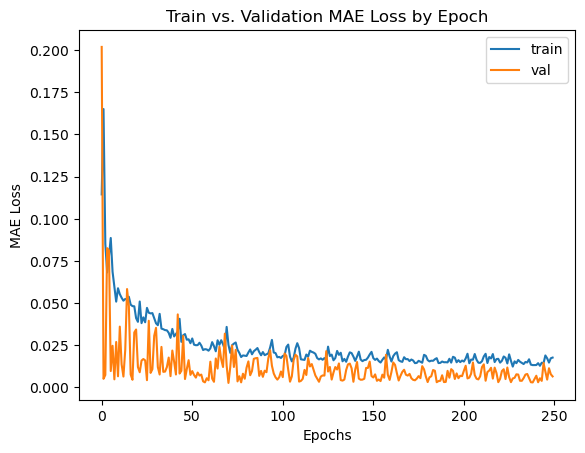

In [50]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Train vs. Validation MAE Loss by Epoch')
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()

In [51]:
# Predict on Train and Test data
LSTM_train_pred = model.predict(LSTM_X_train).flatten()
LSTM_val_pred = model.predict(LSTM_X_val).flatten()
LSTM_test_pred = model.predict(LSTM_X_test).flatten()

1/1 [==============================] - 0s 80ms/step


In [52]:
# Convert into pred and observed dataframe for RMSE
LSTM_train_results_df = pd.DataFrame(data={'Predictions': LSTM_train_pred, 'Observed': LSTM_y_train})
LSTM_val_results_df = pd.DataFrame(data={'Predictions': LSTM_val_pred, 'Observed': LSTM_y_val})
LSTM_test_results_df = pd.DataFrame(data={'Predictions': LSTM_test_pred, 'Observed': LSTM_y_test})

In [53]:
# Calculate RMSE on Train and test data:
LSTM_rmse_train = np.sqrt(mean_squared_error(LSTM_train_results_df['Predictions'], LSTM_train_results_df['Observed']))
LSTM_rmse_val = np.sqrt(mean_squared_error(LSTM_val_results_df['Predictions'], LSTM_val_results_df['Observed']))
LSTM_rmse_test = np.sqrt(mean_squared_error(LSTM_test_results_df['Predictions'], LSTM_test_results_df['Observed']))

print('Train RMSE: %.3f' % LSTM_rmse_train)
print('Val RMSE: %.3f' % LSTM_rmse_val)
print('Test RMSE: %.3f' % LSTM_rmse_test)

Train RMSE: 0.030
Val RMSE: 0.008
Test RMSE: 0.006


In [54]:
LSTM_trial_pred = model.predict(LSTM_X[120:]).flatten()

2/2 [==============================] - 0s 33ms/step


In [55]:
# LSTM_results = pd.concat([LSTM_train_results_df, LSTM_val_results_df, LSTM_test_results_df]).set_index(monthly_pca_bitcoin_df.index[5:])
LSTM_results = results_original_scale(source_array=LSTM_X_prime,
                                      predictions=LSTM_trial_pred,
                                      scaler=scaler,
                                      index=X_prime.index,
                                      window=Window)

In [56]:
LSTM_trial_pred = model.predict(LSTM_X).flatten()

5/5 [==============================] - 0s 32ms/step


In [57]:
LSTM_trial_results = pd.DataFrame(data={'Observed': LSTM_y, 'Predictions': LSTM_trial_pred})

<Axes: >

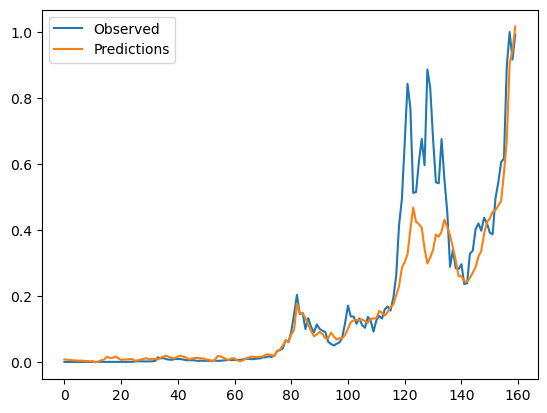

In [58]:
LSTM_trial_results.plot()

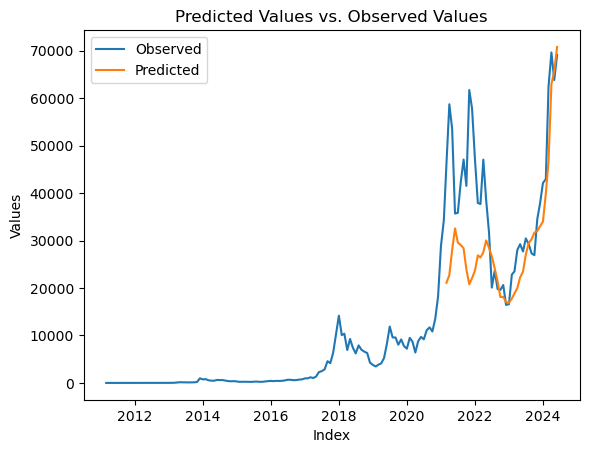

In [59]:
plt.plot(LSTM_results['Observed'], label='Observed')
plt.plot(LSTM_results['Predictions'], label='Predicted')
plt.title('Predicted Values vs. Observed Values')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

<Axes: >

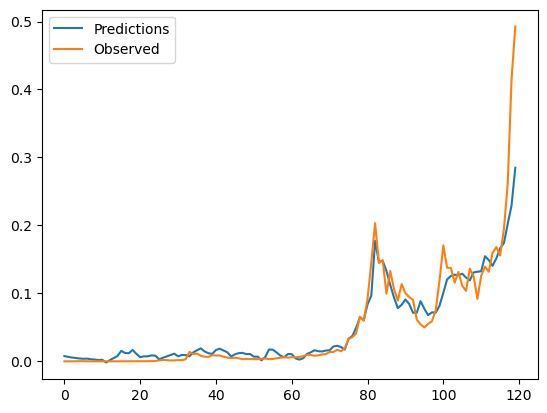

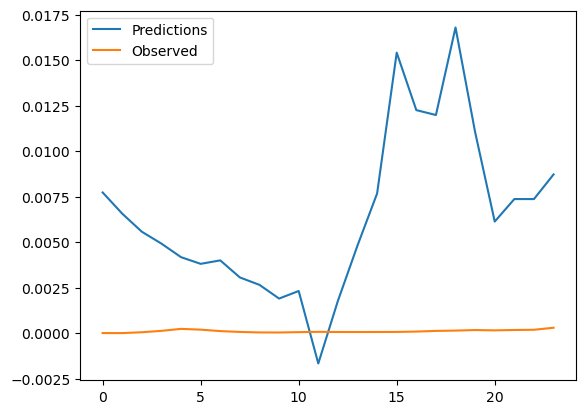

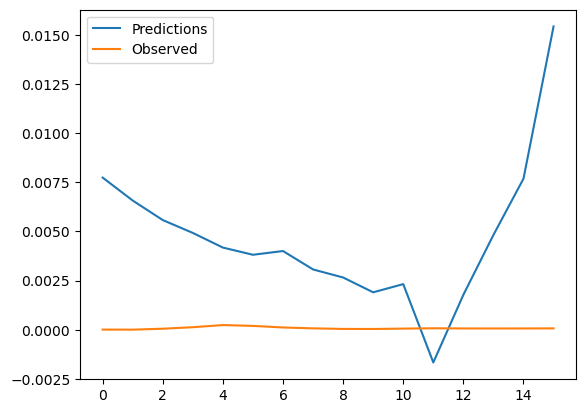

In [60]:
LSTM_train_results_df.plot()
LSTM_val_results_df.plot()
LSTM_test_results_df.plot()

Much more Accurate! Now let's see about if there are any hyper-parameters we can adjust to make this model even better.

In [61]:
def LSTM_model_gen(X_y_list, num_layers, num_nodes, dropout, loss, optimizer):
    '''
    Generates a list of models to be iterated
    '''
    params = {'num_layers': None, 'num_nodes': None, 'dropout': None, 'loss': None, 'optimizer': None, 'Data': None}
    models_dict = {}
    # Generate list of models and dictionary of parameters
    for func in loss:
        for optim in optimizer:
            for i in num_layers:
                for j in num_nodes:
                    for drop in dropout:
                        for tup in X_y_list:
                            model = Sequential()
                            if i == 1:
                                model.add(LSTM(j, input_shape=(tup[0].shape[1], tup[0].shape[2])))
                                model.add(Dropout(drop))
                                model.add(Dense(1))
                                model.compile(loss=func, optimizer=optim)
                                params_list = [i, j, drop, func, optim, tup]
                                keys_list = params.keys()
                                params = dict(zip(keys_list, params_list))
                                models_dict[f'Model{len(models_dict) + 1}'] = (model, params)
                            else:
                                model.add(LSTM(j, input_shape=(tup[0].shape[1], tup[0].shape[2]), return_sequences=True))
                                for _ in range(i-1):
                                    model.add(LSTM(j, return_sequences=True))
                                model.add(Dropout(drop))
                                model.add(Dense(1))
                                model.compile(loss=func, optimizer=optim)
                                params_list = [i, j, drop, func, optim, tup]
                                keys_list = params.keys()
                                params = dict(zip(keys_list, params_list))
                                models_dict[f'Model {len(models_dict) + 1}'] = (model, params)

    return models_dict

def viz_model(history, key, models_dict, results):
    _, (ax1,ax2) = plt.subplots(ncols=2,figsize=(25, 7))
    # Plot training and Validation scores by Epoch
    ax1.plot(history.history['loss'], label='train')
    ax1.plot(history.history['val_loss'], label='test')
    ax1.set_title(f'Train vs. Validation {list(models_dict[key][1].keys())[3].upper()} Loss by Epoch')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(f'{list(models_dict[key][1].keys())[3].upper()} Loss')
    ax1.legend()

    # Rough Plot of Predicted against True Values Stationary Transformation
    ax2.plot(results['Observed'], label='observed', color='b')
    ax2.plot(results['Predictions'], label='predicted', color='r')
    ax2.set_title('Predicted Values vs. Observed Values')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Values in $s')
    ax2.legend()

    # Plot of original Value data against Predicted (Transformed) Data
    # ax3.plot(monthly_pca_bitcoin_df.index, monthly_pca_bitcoin_df['Market Price'], label='Observed', color='b')
    # ax3.plot(LSTM_X_prime.index, np.exp(np.cumsum(inv_test_pred)) +  monthly_pca_bitcoin_df['Market Price'].iloc[-len(inv_test_pred)], color='r', label='Predicted')
    # ax3.set_title('Predicted Values vs. Observed Values Original Scale')
    # ax3.set_xlabel('Date')
    # ax3.set_ylabel('Values in $s')
    # ax3.legend()
                
    plt.suptitle(f'{key} Performance Visualization')
    plt.show()

def model_metrics(key, models_dict, rmse_train, rmse_val, rmse_test):
    # Print Model Params and RMSE metrics before Plotting
    print('#######################')
    print(f'{key} Parameters:')
    for key2 in models_dict[key][1].keys():
        print(f'\t{key2}: {models_dict[key][1][key2]}')
    print('#######################')
    print('Train RMSE: %.3f' % rmse_train)
    print('Val RMSE: %.3f' % rmse_val)
    print('Test RMSE: %.3f' % rmse_test)
    print('#######################\n')
                        
def windowed_X_y_gen(df, window):
    '''
    takes a dataset and and a window size and returns a list of tuples containing in order:
    X_train, y_train, X_val, y_val, X_test, y_test
    to be iterated by the LSTM_tuner function
    '''
    X_y_list = []
    for size in window:
        X, y = to_X_y(df, window=size)
        X_train, y_train, X_val, y_val, X_test, y_test = train_test_val_split(X, y)
        X_y_list.append((X_train, y_train, X_val, y_val, X_test, y_test))
    return X_y_list
    
def LSTM_tuner(X_y_list, num_epochs, batch_size, num_layers, num_nodes, dropout, loss, optimizer, scaler, callback):
    '''
    Takes in previously formated X, and y np.Arrays for LSTM modeling and tunes model parameters and model layers
    in order to find the best model for the dataset.
    '''
    # Instantiate Models
    best_model = {'Model #': None, 'Model': None, 'History': None, 'Params': None, 'MAE': None, 'RMSE trainset score': None, 'RMSE testset score': None, 'Window': None}
    print("Initializing Models Dictionary....")
    models_dict = LSTM_model_gen(X_y_list=X_y_list,
                                    num_layers=num_layers,
                                    num_nodes=num_nodes,
                                    dropout=dropout,
                                    loss=loss,
                                    optimizer=optimizer)
    
    print(f"Complete:    Num Models: {len(models_dict)}")
    print("########################\n")
    print('Training Models....')
    # Train Model
    for i in num_epochs:
        for k in batch_size:
            for key in models_dict.keys():
                print(f'\tTraining {key}....')
                history = models_dict[key][0].fit(models_dict[key][1]['Data'][0],
                            models_dict[key][1]['Data'][1],
                            callbacks=[callback],
                            epochs=i,
                            batch_size=k,
                            validation_data=(models_dict[key][1]['Data'][2], models_dict[key][1]['Data'][3]),
                            verbose=0,
                            shuffle=False)
                
                # Predict on Train and Test data
                print(f'Evaluating {key}....')
                # train_pred = models_dict[key][0].predict(X_y_list[tup][0])
                # test_pred = models_dict[key][0].predict(X_y_list[tup][2])
                train_pred = model.predict(models_dict[key][1]['Data'][0]).flatten()
                val_pred = model.predict(models_dict[key][1]['Data'][2]).flatten()
                test_pred = model.predict(models_dict[key][1]['Data'][4]).flatten()

                # convert from 3 dimensions to 2 dimensions X_train and Predictions
                # train_pred_dim1, train_pred_dim2 = train_pred.shape[0], train_pred.shape[-1]
                # test_pred_dim1, test_pred_dim2 = test_pred.shape[0], test_pred.shape[-1]
                
                # new_X_train = X_train.reshape((X_train.shape[0], X_train.shape[2]))
                # new_X_test = X_test.reshape((X_test.shape[0], X_test.shape[2]))
                # new_train_pred = train_pred.flatten().reshape(train_pred_dim1, train_pred_dim2)
                # new_test_pred = test_pred.flatten().reshape(test_pred_dim1, test_pred_dim2)

                # Create inverted sets
                # inv_train_pred = np.concatenate((new_X_train, new_train_pred), axis=1)
                # inv_test_pred = np.concatenate((new_X_test, new_test_pred), axis=1)

                # Transform to original scale
                # inv_train_pred = scaler.inverse_transform(inv_train_pred)
                # inv_test_pred = scaler.inverse_transform(inv_test_pred)
                

                # Predicted values on training data
                # inv_train_pred = inv_train_pred[:,-1] 
    
                # Predicted values on testing data
                # inv_test_pred = inv_test_pred[:,-1] 

                # Scale back original train and test labels:
                #   Train set:
                # new_y_train = y_train.reshape((len(y_train), 1))
                # inv_y_train = np.concatenate((new_X_train, new_y_train), axis=1)
                # inv_y_train = scaler.inverse_transform(inv_y_train)
                # inv_y_train = inv_y_train[:,-1]

                #   Test set:
                # new_y_test = y_test.reshape((len(y_test), 1))
                # inv_y_test = np.concatenate((new_X_test, new_y_test), axis=1)
                # inv_y_test = scaler.inverse_transform(inv_y_test)
                # inv_y_test = inv_y_test[:,-1]

                # Calculate RMSE on Train and test data:
                train_results_df = pd.DataFrame(data={'Predictions': train_pred, 'Observed': models_dict[key][1]['Data'][1]})
                val_results_df = pd.DataFrame(data={'Predictions': val_pred, 'Observed': models_dict[key][1]['Data'][3]})
                test_results_df = pd.DataFrame(data={'Predictions': test_pred, 'Observed': models_dict[key][1]['Data'][5]})
                
                final_pred = model.predict(LSTM_X[120:]).flatten()
                
                rmse_train = np.sqrt(mean_squared_error(train_results_df['Predictions'], train_results_df['Observed']))
                rmse_val = np.sqrt(mean_squared_error(val_results_df['Predictions'], val_results_df['Observed']))
                rmse_test = np.sqrt(mean_squared_error(test_results_df['Predictions'], test_results_df['Observed']))
                
                results = results_original_scale(source_array=LSTM_X_prime,
                                      predictions=final_pred,
                                      scaler=scaler,
                                      index=X_prime.index,
                                      window=models_dict[key][1]['Data'][0].shape[1])

                # Reshape data for plotting
                # inv_y_test = inv_y_test.reshape(-1,1)
                
                params = [key, models_dict[key][0], history, models_dict[key][1], min(history.history['val_loss']), rmse_train, rmse_test, models_dict[key][1]['Data'][0].shape[1]]
                if best_model['Model'] == None:
                    keys_list = best_model.keys()
                    best_model = dict(zip(keys_list, params))
                    print('Best Model updated')
                    print(f'{key}:  {best_model}')
                    print('Graphing...')
                    viz_model(history, key, models_dict, results)
                    model_metrics(key, models_dict, rmse_train, rmse_test)
                elif min(history.history['val_loss']) < best_model['MAE']:
                    keys_list = best_model.keys()
                    best_model = dict(zip(keys_list, params))
                    print('Best Model updated')
                    print(f'{key}:  {best_model}')
                    print('Graphing...')
                    viz_model(history, key, models_dict, results)
                    model_metrics(key, models_dict, rmse_train, rmse_val, rmse_test)

    print('...finished\n')
    print('Best Model:')
    print('###################')
    for keys in best_model.keys():
        print(f'\t{keys}:   {best_model[keys]}')
    print('###################')
    return best_model


Initializing Models Dictionary....
Complete:    Num Models: 1530
########################

Training Models....
	Training Model1....
Evaluating Model1....
2/2 [==============================] - 0s 3ms/step
Best Model updated
Model1:  {'Model #': 'Model1', 'Model': <keras.engine.sequential.Sequential object at 0x000002371D08B880>, 'History': <keras.callbacks.History object at 0x00000234EF4FB6A0>, 'Params': {'num_layers': 1, 'num_nodes': 100, 'dropout': 0.1, 'loss': 'mae', 'optimizer': 'adam', 'Data': (array([[[0.48287346, 0.43040216, 0.3419535 , ..., 0.5968853 ,
         0.35837074, 0.70168439],
        [0.48267999, 0.42805683, 0.34304022, ..., 0.59977771,
         0.34918175, 0.70209813],
        [0.48283184, 0.43736118, 0.34140905, ..., 0.6007618 ,
         0.34483329, 0.70491325]],

       [[0.48267999, 0.42805683, 0.34304022, ..., 0.59977771,
         0.34918175, 0.70209813],
        [0.48283184, 0.43736118, 0.34140905, ..., 0.6007618 ,
         0.34483329, 0.70491325],
        [0.48

ValueError: too many values to unpack (expected 2)

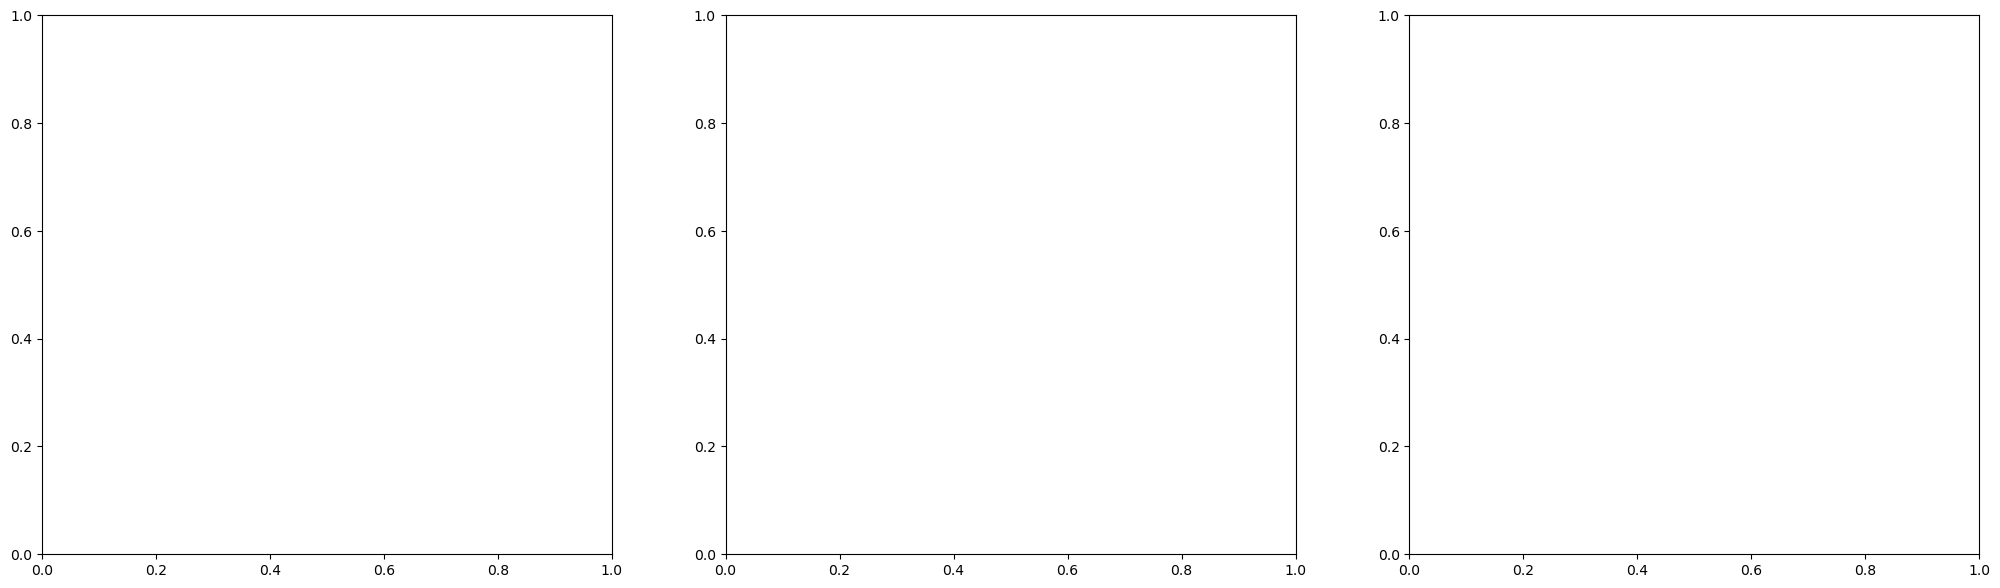

In [94]:
num_epochs = np.arange(25, 125, 25)
batch_size = np.arange(10, (len(LSTM_X_prime) + 10), 10)
num_layers = [1, 2, 3]
num_nodes = np.arange(100, 525, 25)
dropout = np.arange(0.1, 0.35, 0.05)
loss = ['mae']
optimizer = ['adam']
callback = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, mode='min')
Window = np.arange(3, 9, 1)

###DEBUG SET###
# num_epochs = [150, 200, 250]
# batch_size = [50, 100, 150]
# num_layers = [1, 2, 3]
# num_nodes = [100, 250, 500]
# dropout = [0.15, 0.2, 0.25]
# loss = ['mae']
# optimizer = ['adam']
# callback = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True, mode='min')

# Divide Data into Train and Test data
# LSTM_X_prime = scaler.fit_transform(X_prime)
# LSTM_X_train_size = int(len(LSTM_X_prime) * 0.80)
# LSTM_X_test_size = len(LSTM_X_prime) - LSTM_X_train_size

# LSTM_train, LSTM_test = LSTM_X_prime[0:LSTM_X_train_size, :], LSTM_X_prime[LSTM_X_train_size:len(LSTM_X_prime),:]
# LSTM_X_train, LSTM_y_train = LSTM_train[:, :-1], LSTM_train[:, -1]
# LSTM_X_test, LSTM_y_test = LSTM_test[:, :-1], LSTM_test[:, -1]

# Convert X data into correct dimension for LSTM Model
# LSTM_X_train = LSTM_X_train.reshape((LSTM_X_train.shape[0], 1, LSTM_X_train.shape[1]))
# LSTM_X_test = LSTM_X_test.reshape((LSTM_X_test.shape[0], 1, LSTM_X_test.shape[1]))
X_y_list = windowed_X_y_gen(LSTM_X_prime, window=Window)

LSTM_best_model = LSTM_tuner(X_y_list=X_y_list,
                            #  X_train=LSTM_X_train,
                            #  y_train=LSTM_y_train,
                            #  X_test=LSTM_X_test,
                            #  y_test=LSTM_y_test,
                             num_epochs=num_epochs,
                             batch_size=batch_size,
                             num_layers=num_layers,
                             num_nodes=num_nodes,
                             dropout=dropout,
                             loss=loss,
                             optimizer=optimizer,
                             scaler=scaler,
                             callback=callback)

Our LSTM Modeling is looking excellent however leave no stone unturned.  Considering how well it works, there is concernt about bias in the modeling inspite of efforts to negate that possibility, however, deep learning models from Keras TensorFlow seems to work very well with the data and we should perhaps try a CNN model which can perform the same task more quickly due to its lightness and conveniently has windowing (kernel) packed into it which could make the process easier.  However our purpose in establish the capacity of a deep learning model against the BitCoin market value time series.  Our next class of model to test will be the VARIMAX


- ##### VARIMAX  Models #####
***
- Setup VARIMAX data sets for X and y inputs
- Setup scalars and metrics
- Create Model to test
- Establish Hyper Parameters to tune
- Automate model Tuning
- Select best Model.

In [27]:
# SETUP VARIMAX X AND y
# We will require stationary Time Series and scaled data for this model so we will use our original X_prime as a starting point
scaler = MaxAbsScaler()
Multivar_prime = scaler.fit_transform(X_prime)
Multivar_prime = pd.DataFrame(Multivar_prime, columns=X_prime.columns)

Train_multivar = Multivar_prime.iloc[:(len(Multivar_prime) - int(len(Multivar_prime) * 0.25))]
Test_multivar = Multivar_prime.iloc[(len(Multivar_prime) - int(len(Multivar_prime) * 0.25)):]

In [28]:
Train_multivar.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,Market Price
0,-0.002760,0.003263,0.081586,-0.095817,-0.028633,-0.001544,0.036595,0.030768,-0.147325,-0.022238,0.046022,-0.026455,-0.028016
1,-0.003135,-0.000842,0.083103,-0.091213,-0.024681,-0.004332,0.038011,0.028913,-0.142862,-0.017500,0.032360,-0.025881,0.686338
2,-0.002841,0.015440,0.080826,-0.081916,-0.036257,0.011724,0.025691,0.014110,-0.150983,-0.015888,0.025895,-0.021975,0.237647
3,-0.003188,-0.013987,0.079452,-0.096350,-0.017868,-0.019211,0.043617,0.035242,-0.133877,-0.017636,0.028143,-0.021333,0.042283
4,-0.002084,0.019813,0.077463,-0.082436,-0.031154,0.014306,0.029581,0.025069,-0.144841,-0.017712,0.022301,-0.017992,0.706434


In [29]:
Test_multivar.head()

,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9,PCA10,PCA11,PCA12,Market Price
124,0.099854,-0.296431,0.190204,0.064286,0.140986,0.010067,-0.004821,-0.026333,0.087246,0.130355,0.009312,0.131744,0.106230
125,0.113202,-0.275133,0.248603,0.171343,0.137259,-0.000552,0.042123,-0.057186,0.213059,0.354924,-0.113331,0.078831,0.181622
126,0.087823,-0.064949,0.492147,0.246333,0.180179,-0.034701,0.062418,-0.153594,0.019416,0.638106,0.229120,0.036555,0.147656
127,0.111427,-0.015689,0.669446,0.249992,0.060949,0.111715,0.040609,-0.077836,0.115772,0.573129,0.221605,0.126071,-0.056199
128,-0.051325,-0.086536,0.089551,0.172005,0.149217,-0.084525,0.054921,-0.111905,0.007473,0.181190,-0.188756,-0.042627,-0.249149


We've scaled and separated our data into X and y Values, we shall continue to use MAE and RMSE as metrics to determine our best model.

In [30]:
# Train test split
# X_multivar_train, X_multivar_test, y_multivar_train, y_mulitvar_test = train_test_split(X_multivar, y_multivar, test_size=.25)

In [31]:
# Test Model
model = VARMAX(
    Train_multivar,
    order=(1,1),
    seasonal_order=(0,0,0,0,),
    mle_regression=True,
    filter_concetrated=True
)

/home/mvanslyke/mambaforge/lib/python3.10/site-packages/statsmodels/tsa/statespace/varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


In [37]:
model_fit = model.fit(disp=True)
predictions = model_fit.predict(len(Train_multivar), len(Test_multivar) - 1)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          442     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.55480D+01    |proj g|=  6.80861D+02


 This problem is unconstrained.



At iterate    1    f= -1.55480D+01    |proj g|=  6.80861D+02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  442      1      3      1     0     0   6.809D+02  -1.555D+01
  F =  -15.548040725903158     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


ValueError: Prediction must have `end` after `start`.

In [33]:
model_fit.summary()

Dep. Variable:,"['PCA1', 'PCA2', 'PCA3', 'PCA4', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA9', 'PCA10', 'PCA11', 'PCA12', 'Market Price']",No. Observations:,124
Model:,"VARMA(1,1)",Log Likelihood,1927.957
,+ intercept,AIC,-2971.914
Date:,"Wed, 29 May 2024",BIC,-1725.350
Time:,09:28:17,HQIC,-2465.530
Sample:,0,,
,- 124,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.04, 0.02, 0.01, 0.01, 0.00, 0.01, 0.00, 0.00, 36.57, 0.01, 4.17, 0.03, 0.14",Jarque-Bera (JB):,"105.35, 128.79, 51.42, 172.02, 303.43, 93.10, 30.19, 224.52, 5.29, 28.02, 20.88, 476.36, 250.21"
Prob(Q):,"0.84, 0.89, 0.94, 0.92, 0.99, 0.93, 0.96, 0.95, 0.00, 0.94, 0.04, 0.87, 0.71",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.07, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"7.78, 0.98, 5.45, 0.75, 0.97, 0.73, 1.01, 0.97, 4.13, 5.24, 2.37, 5.74, 0.12",Skew:,"-0.44, 1.29, 0.68, 1.41, -0.33, 0.98, 0.47, 0.63, 0.12, -0.72, -0.29, -1.49, 1.59"


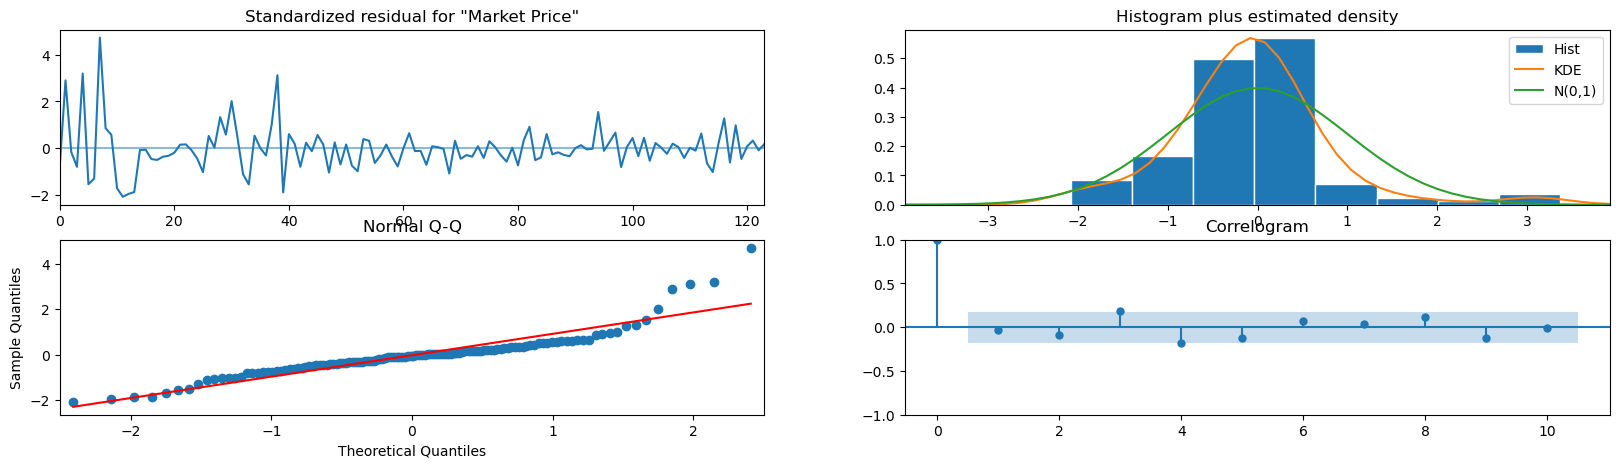

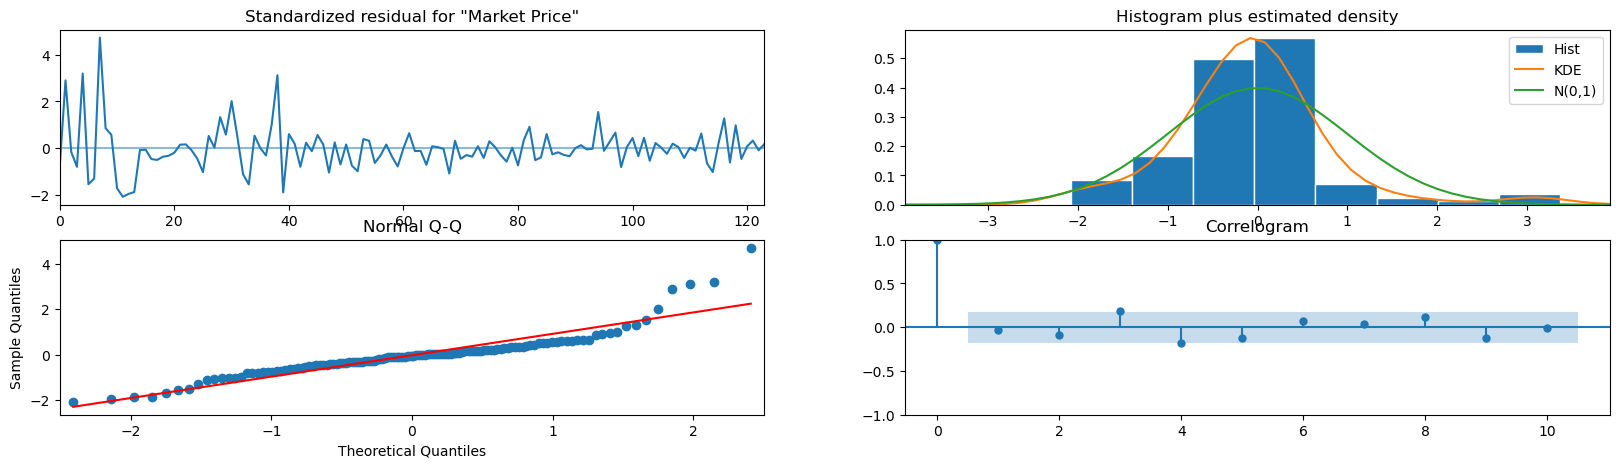

In [34]:
model_fit.plot_diagnostics(12, figsize=(20,5))

In [36]:
multivar_results = pd.DataFrame()
multivar_results['Predictions'] = model_fit.simulate(endog=Test_multivar['Market Price'], nsimulations=len(Test_multivar)).reset_index(drop=True).close
multivar_results['Observed'] = Test_multivar.reset_index(drop=True).close

multivar_results.plot(figsize=(20, 5), title='Prediction vs. Observed')

TypeError: Representation.extend() got multiple values for argument 'endog'